# Ada - Milestone 2





## Installations

In [ ]:
!pip install pandas==1.3.4

In [ ]:
!pip install tqdm

In [ ]:
!pip install newspaper3k

In [2]:
pip install --upgrade pandas

     |████████████████████████████████| 11.3 MB 25.6 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


## Importations

In [7]:
import pandas as pd
from tqdm import tqdm
from google.colab import drive
import bz2
import json
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
#import nltk
#nltk.download('punkt') # needed for Article
#from newspaper import Article
import scipy.stats as stats
from scipy.stats import ttest_ind

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The data are too big to have them locally. We thus use google drive to manipulate our data.

In [8]:
drive._mount('/content/drive')

Mounted at /content/drive


## Speaker_attribute Dataset


We first get the parquet file used to describe our data. The table contains the name of a speaker with his aliases, his gender, birth date, occupation, religion, ethnic group, politic orientation, party academical degree and his nationality. 
The link to our dataset will be represented by the column id. This column contains the wikidata identifier of our speaker.

In [ ]:
path_parquet = '/content/drive/MyDrive/ADA/project/Project datasets/speaker_attributes.parquet'
parquet = pd.read_parquet(path_parquet)

In [ ]:
# we only keep the features that are of interest for us
parquet = parquet[['date_of_birth', 'gender', 'occupation', 'id', 'label']]

Here is what our dataset looks like:

In [ ]:
parquet.sample(5)

,date_of_birth,gender,occupation,id,label
5633985,[+1859-09-20T00:00:00Z],[Q6581097],None,Q104703754,Siegfried Hermann
3523150,[+1830-00-00T00:00:00Z],[Q6581097],[Q82955],Q4719349,"Alexander Laird, Jr."
1035491,None,None,[Q1650915],Q100380562,G C Wakchaure
7862850,None,None,[Q1650915],Q102279490,Ulrich Görtz
5286329,None,[Q6581072],None,Q76216281,Amy Mary Louise Peters


Then we process it in order to have the interesting data we want. We only keep the gender, the occupation, the id, the name of the speaker and the date of birth colomns and we check if all these lines are full.

In [ ]:
# Process parquet
nb_data_before = len(parquet)

# Remove rows with gender = None
parquet = parquet[~(parquet.gender.isnull())]
# Keep unique gender
parquet = parquet[parquet.gender.apply(lambda x: len(x)==1)]
nb_diff_data_gender = nb_data_before-len(parquet)

nb_data = len(parquet)
# Remove rows with occupation = None
parquet = parquet[~(parquet.occupation.isnull())]
nb_diff_data_occupation = nb_data-len(parquet)

nb_data = len(parquet)
# Remove rows with date_of_birth = None
parquet = parquet[~(parquet.date_of_birth.isnull())]
# Keep only unique date of birth
parquet = parquet[parquet.date_of_birth.apply(lambda x: len(x)==1)]
nb_diff_data_date_of_birth = nb_data-len(parquet)
# Keep only the year of birth the month and day are not relevant in terms of age
parquet.date_of_birth = parquet.date_of_birth.apply(lambda x : x[0][0:5])


# remove rows with label = None
parquet = parquet[~(parquet.label.isnull())]

#remove rows with id = None
parquet=parquet[~(parquet.id.isnull())]

Here is what our data looks like now.

In [ ]:
parquet.sample(5)

,date_of_birth,gender,occupation,id,label
807547,+1954,[Q6581097],"[Q51751308, Q17516936]",Q87211796,Brent Giles
1519090,+1922,[Q6581097],[Q177220],Q23071342,José Luis Caballero
5529895,+1992,[Q6581072],[Q937857],Q97718612,Rica Bock
5656896,+1999,[Q6581097],[Q10871364],Q105952530,Henry Davis
1686741,+1956,[Q6581097],[Q13570226],Q56033629,Lars Handesten


Here is a small pie graph to see how much data we erased.

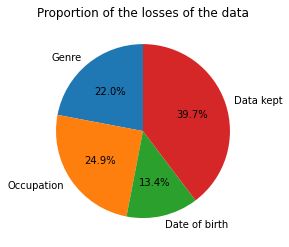

In [ ]:
gender_proportion = nb_diff_data_gender*100.0/nb_data_before
occupation_proportion = nb_diff_data_occupation*100.0/nb_data_before
date_of_birth_proportion = nb_diff_data_date_of_birth*100.0/nb_data_before
data_proportion = len(parquet)*100.0/nb_data_before

y = np.array([gender_proportion, occupation_proportion, date_of_birth_proportion,data_proportion])
labels = ["Genre", "Occupation", "Date of birth", "Data kept"]

plt.title('Proportion of the losses of the data')
plt.pie(y, labels = labels, startangle = 90, autopct='%1.1f%%')
plt.show() 

Here, we convert the columns _gender_ and _occupation_ into what their Qcode mean. To do so, we use the provided csv file wikidata_labels_descriptions_quotebank.csv.bz2 and a dictionnary containing textual descriptions of ids that are not in the provided file because they correspond to redirections.

In [ ]:
path_label_descriptions = '/content/drive/MyDrive/ADA/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2'
string_data = pd.read_csv(path_label_descriptions, compression='bz2', index_col='QID')
quids_redir = {'Q3268166': 'clinical psychologist', 'Q12014399': 'catholic priest', 'Q11819457': 'visual artist',
               'Q12334852': 'sailor', 'Q3186984': 'journalist', 'Q15991263': 'auctioneer', 'Q12455619': 'social worker',
               'Q1248362': 'director of a creative work', 'Q13365117': 'handball player', 'Q21550646': 'glass painter',
               'Q6363085': 'advocate', 'Q16287483': 'opinion journalist', 'Q13424794': 'computational scientist',
               'Q11815360': 'pediatrician', 'Q5568256': 'forester', 'Q6859927': 'lady-in-waiting', 'Q15145782': 'transgender female',
               'Q15145783': 'transgender male'}

In [ ]:
# convert wiki ids to strings ~28min
def convert_id_str(x):
  if (np.array(x) != None).all(): # x is a np.array by default but if None then just None so cast to array otherwise error on .all()
    strings = []
    for id in x:
      # id needs to be in string_data index otherwise error     
      try:
        strings.append(string_data.loc[id]['Label'])
      except KeyError:
        #print('Id: {} was not found in label_descriptions'.format(id))
        if id in quids_redir.keys():
          redirect = quids_redir[id]
          strings.append(redirect)
    return strings
  else:
    return None

parquet[['gender', 'occupation']] = parquet[['gender', 'occupation']].applymap(convert_id_str)

parquet.to_pickle('/content/drive/MyDrive/ADA/project/parquet_proc_str.pkl') 

In [ ]:
parquet = pd.read_pickle('/content/drive/MyDrive/ADA/parquet_proc_str.pkl')

Here is how the speaker attributes dataset finally looks like.

In [ ]:
parquet.sample(5)

,date_of_birth,gender,occupation,id,label
2285791,+1987,[Q6581072],[Q4610556],Q510248,Alice Dellal
2374154,+1990,[Q6581097],[Q937857],Q3844190,Mamoutou N'Diaye
7965312,+0050,[Q6581097],[Q82955],Q1238043,Decimus Plotius Grypus
6660538,+1985,[Q6581072],[Q937857],Q97689975,Ellie Hamon
8228284,+1960,[Q6581097],[Q333634],Q16299826,Ville Keynäs


## Quotebank Dataset


First, we define our processing functions : process_probas and process_qchunk. 

The first one do is used to check if the probability of a speaker for a given quote is more than 70%. We chose that threshold because we want to avoid probabilities close to 0.5, because the odd to make a mistake is 1:1. We want to make sure that our speaker probability is not random. 
We use the second one to clean the data and form our final dataset.

In [ ]:
# Process probas attribute
def process_probas(speakers_probas): # In case the most probable speaker isn't the first one
  # Flatten probas into a single list
  flat = [item for sublist in speakers_probas for item in sublist]
  # Extract probs
  probas = [float(p) for i,p in enumerate(flat) if i%2]
  return (max(probas) > 0.7) # Return 1 if the max proba > 0.7



# Process samples by chunks
def process_qchunk(chunk, path): # Quotebank chunk
  rem = []

  # Drop rows where speaker==None
  initial_n = len(chunk)
  chunk = chunk[chunk.speaker != 'None']
  rem.append(initial_n-len(chunk)) 

  # Keep only quotes with very probable speaker
  initial_n = len(chunk)
  chunk = chunk[chunk.probas.apply(process_probas)] 
  rem.append(initial_n-len(chunk))

  # Keep only numOcurrences > 0 
  initial_n = len(chunk)
  chunk = chunk[chunk.numOccurrences > 0]
  rem.append(initial_n-len(chunk))

  # Keep only qid size=1
  initial_n = len(chunk)
  chunk = chunk[chunk.qids.apply(lambda x: len(x)==1)]
  rem.append(initial_n-len(chunk))

  # Save to pickle
  with open(path, 'ab') as dest: # use pkl.load(dest) to recover **chunks**
    pkl.dump(chunk, dest)

  return rem

Here is where we extract the Quotebank dataset and use the functions defined above.

In [ ]:
# Processing by chunks
years = ['2020', '2019', '2018', '2017', '2016', '2015']

n_chunks = [0]*len(years)    # needed for read back
processing_steps = 4         # known speaker, very probable speaker, numOcurrences > 0, one single qid,
removed = np.zeros((len(years),processing_steps))
initial_n = [0]*len(years)

for i, year in zip(tqdm(range(len(years))), years):

  path_to_sfile = '/content/drive/MyDrive/ADA/Quotebank/quotes-'+year+'.json.bz2' 
  path_to_dfile = '/content/drive/MyDrive/ADA/quotes-'+year+'_processed.pkl' 

  df_reader = pd.read_json(path_to_sfile, lines=True, compression='bz2', chunksize=100000)
  for chunk in df_reader : 
    initial_n[i] += len(chunk)
    removed[i,:] += process_qchunk(chunk, path_to_dfile)
    n_chunks[i] += 1
  print(n_chunks[i])
  print('Year: {}  Inital number of samples: {}  Removed: {}  Total: {} '.format(year, initial_n[i], removed[i,:],
                                                                                 removed[i,:].sum()))

The resulting prints don't appear here because to gain time we processed different years on different computers in parallel, but we used the same code with the years list containing a single year so it's basically the same.

Here is a visualisation of the process of our data.

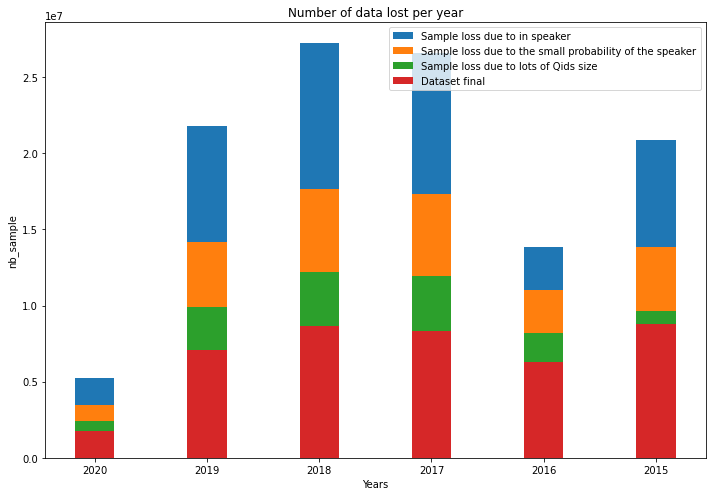

In [ ]:
init_nb_sample = [5244449, 21763302, 27228451, 26611588, 13862129, 20874338]
nb_sample_none_speaker = [3443605, 14183294, 17670419, 17333298, 11035434, 13858038]
nb_sample_prob_speaker = [2419648, 9875076, 12185447, 11948347, 8208739, 9663107]
nb_sample_qid_size = [1743841, 7076288, 8623990, 8329693, 6286262, 8781475]
years = ['2020', '2019', '2018', '2017', '2016', '2015']

ind = np.arange(len(init_nb_sample))

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.bar(x=ind, height=init_nb_sample, width=0.35, align='center', label = 'Sample loss due to in speaker')
ax.bar(x=ind, height=nb_sample_none_speaker, width=0.35, align='center', label = 'Sample loss due to the small probability of the speaker')
ax.bar(x=ind, height=nb_sample_prob_speaker, width=0.35, align='center', label = 'Sample loss due to lots of Qids size')
ax.bar(x=ind, height=nb_sample_qid_size, width=0.35, align='center', label = 'Dataset final')


plt.xticks(ind, years)
plt.title('Number of data lost per year')
plt.legend()
plt.xlabel('Years')
plt.ylabel('nb_sample')
plt.tight_layout()
plt.show()

We can see that 2020 has much less quotes than the other years. Moreover, we see that we keep a third of our original data for our project.

We then extract the name of the author of the articles using the urls and determine his/her gender.


First we need to train a naive Bayes classifier from NLTK to obtain the gender of the author using the name_gender_dataset.csv made available by the Center for Machine Learning and Intelligent Systems of the University of California, Irvine.

In [ ]:
# importing name-gender dataset
df_names = pd.read_csv('/content/drive/MyDrive/ADA/project/name_gender_dataset.csv')
df_names = df_names[['Name', 'Gender']]
df_names

,Name,Gender
0,James,M
1,John,M
2,Robert,M
3,Michael,M
4,William,M
...,...,...
147264,Zylenn,M
147265,Zymeon,M
147266,Zyndel,M
147267,Zyshan,M


In [ ]:
# checking dataset
# no None
print('Number of none present in names: {}  Number of none present in gender: {}'.format(
      df_names.Name.isnull().sum(), df_names.Gender.isnull().sum()))
# balanced
print('Number of male names: {}  Number of female names: {}'.format(
      (df_names.Gender=='M').sum(), (df_names.Gender=='F').sum()))
# only males and females
print('Only male/female genders ? : {}'.format(((df_names.Gender=='M').sum()+(df_names.Gender=='F').sum())==len(df_names)))

Number of none present in names: 0  Number of none present in gender: 0
Number of male names: 57520  Number of female names: 89749
Only male/female genders ? : True


In [ ]:
# feature extractor
def gender_features(word):
  return {'last_letter':word[-1],
          'last_2letters':word[-2:]}

In [ ]:
# preparing a list of examples and corresponding class labels.
labeled_names = [(name, gender) for (name, gender) in zip(df_names.Name, df_names.Gender)]

# we use the feature extractor to process the names data.
featuresets = [(gender_features(n), gender) for (n, gender) in labeled_names]

# Divide the resulting list of feature
# sets into a training set and a test set.
train_set, test_set = train_test_split(featuresets, test_size=0.25)

clf = nltk.NaiveBayesClassifier.train(train_set)

print(nltk.classify.accuracy(clf, train_set))
print(nltk.classify.accuracy(clf, test_set))

0.7635874731781513
0.7603889401922972


To extract the name of the author of the article containing the quote, we use the newspaper3k library which provides an implementation of the author extractor that can be used easily. The gender of the authors will then be determined by the classifier previously trained.

In [ ]:
# Extracts one author name (if found) for each url (if valid)                   11min for 188 quote samples
def extract_authors(urls): # Using newspaper3k, try & except because link may be not valid (404 etc.)
  names = []               # We could use status code of request otherwise 
  for link in urls:
    article = Article(link)
    try: 
      article.download()
      article.parse()
      article.nlp()
    except:
      names.append('Invalid link')
    else:
      authors = article.authors # could be empty (author not found or article restricted to members-only, ex: http://sunshinecoastdaily.com.au/news/incredible-upside-to-horn-vs-tszyu-bloody-sunday-d/3974224/)
      if len(authors)==0:
        names.append(None)
      else:
        names.append(authors[0]) # with [0], it doesn't handle the case when there are several authors  but avoids getting a lot of extra stuff that aren't names    
  return names

# determines the gender of the extracted names using the trained classifier
def gender_from_name(names):
  # names can contain None, invalid link or (complete) names
  # classifier clf used as global because unable to pass it as argument when using .apply(func,args=(clf))
  genders = []
  for name in names:
    if (name==None) or (name=='Invalid link'):
      genders.append(None)
    else:
      sub = name.split(' ')
      firstname = sub[0]
      if len(firstname) > 1: # to safely extract features
        genders.append(clf.classify(gender_features(firstname)))
      else:
        genders.append(None)
  
  return genders


# Second major processing step where we merge the datasets and extract the 
# authors and their gender.
def process_qchunk2(chunk, path, parquet):
  # Merge with parquet
  initial_n = len(chunk)
  chunk.qids = chunk.qids.apply(lambda x: x[0]) # Extract qid string
  # Keep the label of the parquet to uniform the names of the speaker
  chunk = chunk.merge(parquet, left_on='qids', right_on='id').drop(columns=['speaker'])
  
  # extract authors 
  #chunk['authors'] = chunk.urls.apply(extract_authors) # need to find an alternative, this is way too slow
  # extract author gender
  #chunk['author_gender'] = chunk.authors.apply(gender_from_name)

  chunk.gender = chunk.gender.apply(lambda x: x[0]) # Extract gender string
  rem = initial_n-len(chunk)
  
  # Save to pickle
  with open(path, 'ab') as dest: # use pkl.load(dest) to recover **chunks**
    pkl.dump(chunk, dest)

  return rem, chunk

Now that we have all the necessary functions to  do the merge and extract the author and determine his/her gender, we can proceed to the next processing step on the Quotebank dataset. Unfortunately we didn’t have time to completely run the second major processing step where we merge the parquet file with the quotebank dataset and extract the author and his/her gender. We only perform the merge. The main problem seems to be the extraction of the author of the article for each url contained in the quote samples, which takes too much time.

In [ ]:
#years = ['2020', '2019', '2018', '2017', '2016', '2015']
#n_chunks = [53, 218, 273, 267, 139, 208]
years = ['2017', '2016', '2015']
n_chunks = [267, 139, 208]
M = [0]*len(years) 
F = [0]*len(years) 
removed = [0]*len(years)  # by merge
initial_n = [0]*len(years)

for i,year in enumerate(years):

  path_to_sfile = '/content/drive/MyDrive/Results/quotes-'+year+'_processed.pkl' 
  path_to_dfile = '/content/drive/MyDrive/ADA/project/quotes-'+year+'_processed_merged.pkl' 
  
  with open(path_to_sfile, 'rb') as f:
    for chunk_idx in range(n_chunks[i]):
      chunk = pkl.load(f)
      initial_n[i] += len(chunk)
      tmp_rem, chunk = process_qchunk2(chunk, path_to_dfile, parquet)
      removed[i] += tmp_rem
      F[i] += chunk['gender'].value_counts().sort_index()[0] # for initial analysis
      M[i] += chunk['gender'].value_counts().sort_index()[1]
  
  print('Year: {}  Number of processed samples: {}  Number of samples removed by merge: {}'.format(
        year, initial_n[i], removed[i]))

Year: 2017  Number of processed samples: 8329693  Number of samples removed by merge: 1115286
Year: 2016  Number of processed samples: 4357542  Number of samples removed by merge: 577531
Year: 2015  Number of processed samples: 6675553  Number of samples removed by merge: 877446


It seems that the number of chunks that have actually been written after the first processing step for the year 2015 is one less than what we counted, which caused this error. The following plot should be correct though as the error stems from trying to read an additionnal (non-existing) chunk, which means that we already have read all the data from that year.

# Milestone 3

## Raw analysis


### Repartion men-women in the quotes

First we plot the data, year per year. We just sum the number of women and the number of men over the years. 

In [16]:
n_chunks = [208, 139, 267, 273, 218, 53]
years = ['2015','2016','2017','2018','2019','2020']

In [17]:
M = [0]*len(years) 
F = [0]*len(years) 

for i,year in enumerate(years):

  path_to_sfile = '/content/drive/MyDrive/Results/quotes-'+year+'_processed_merged.pkl'
  
  with open(path_to_sfile, 'rb') as f:
    for chunk_idx in range(n_chunks[i]):
      chunk = pkl.load(f)
      F[i] += chunk['gender'].value_counts().sort_index()[0] # for initial analysis
      M[i] += chunk['gender'].value_counts().sort_index()[1]

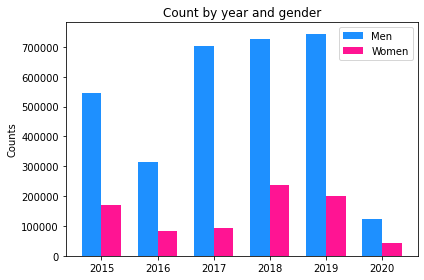

In [18]:
x = np.arange(len(years))  # the years locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, M, width, label='Men',color='dodgerblue')
rects2 = ax.bar(x + width/2, F, width, label='Women',color="deeppink")

ax.set_ylabel('Counts')
ax.set_title('Count by year and gender')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

fig.tight_layout()

plt.show()

Because some years have less data, we choose to make the same plot, only with percentage, to be able to compare the years between them. 

In [19]:
total = [x + y for x, y in zip(F, M)]
F_p = [100*x/y for x, y in zip(F, total)]
M_p = [100*x/y for x, y in zip(M, total)]

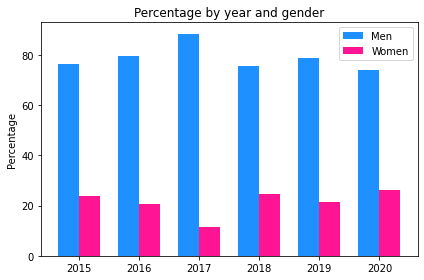

In [21]:
x = np.arange(len(years))  
width = 0.35  
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, M_p, width, label='Men',color='dodgerblue')
rects2 = ax.bar(x + width/2, F_p, width, label='Women',color="deeppink")

ax.set_ylabel('Percentage')
ax.set_title('Percentage by year and gender')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

fig.tight_layout()

plt.show()

The percentage seems to be quite constant over our period of time. We only observe a decrease in the percentage of women speaker in 2018.

In [36]:
Z, pvalue = proportions_ztest([F[0],F[5]],[total[0],total[5]],alternative='smaller') 
print(pvalue)

4.814710546166949e-96


We can see that the p-value is nearly 0 so there the proportion of women in 2020 in statistically greater than the proportion in 2015

In [38]:
print("Proportion of women and men in 2015 : {} {}".format(F[0]/total[0], M[0]/total[0]))
print("Proportion of women and men in 2020 : {} {}".format(F[5]/total[5], M[5]/total[5]))

Proportion of women and men in 2015 : 0.2370404829027973 0.7629595170972027
Proportion of women and men in 2020 : 0.2612083433229441 0.7387916566770558


### Repartition of the occurence of speak: are you quoted more often if you are a man or if you are a woman?

In [9]:
unique_person_2015 = pd.DataFrame()
unique_person_2016 = pd.DataFrame()
unique_person_2017 = pd.DataFrame()
unique_person_2018 = pd.DataFrame()
unique_person_2019 = pd.DataFrame()
unique_person_2020 = pd.DataFrame()
unique_person=[unique_person_2015, unique_person_2016, unique_person_2017, unique_person_2018, unique_person_2019, unique_person_2020]
years = ['2015','2016','2017','2018','2019','2020']
n_chunks = [208, 139, 267, 273, 218, 53]
for index,year in enumerate(years) : 
  path_to_sfile = '/content/drive/MyDrive/Results/quotes-'+year+'_processed_merged.pkl'

  unique_chunk = pd.DataFrame()

  with open(path_to_sfile, 'rb') as f:
    for chunk_idx in range(n_chunks[index]):
      chunk = pkl.load(f)
      unique_chunk_new = chunk[["gender","qids", "label"]]
      unique_chunk = unique_chunk.append(pd.DataFrame(unique_chunk_new)).drop_duplicates(subset="qids")
  unique_person[index] = unique_chunk

In [10]:
for index,year in enumerate(years) : 
  path_to_sfile = '/content/drive/MyDrive/Results/quotes-'+year+'_processed_merged.pkl'

  unique_chunk = pd.DataFrame()

  with open(path_to_sfile, 'rb') as f:
    for chunk_idx in range(n_chunks[index]):
      chunk = pkl.load(f)
      unique_chunk_new = chunk.groupby("qids",as_index=False)[["numOccurrences","qids"]].agg("sum")
      unique_chunk = unique_chunk.append(pd.DataFrame(unique_chunk_new))
  unique_chunk = unique_chunk.groupby("qids",as_index=False)[["numOccurrences","qids"]].agg("sum")
  unique_person[index] = unique_person[index].merge(unique_chunk,on="qids")

100 people more quoted

In [ ]:
copy=unique_person.copy()
for index in range (6):
  tab=copy[index]
  tab=tab.sort_values("numOccurrences", ascending=False)
  tab=tab.iloc[0:100,]
  copy[index]=tab
  print((years[index]))
  print((copy[index]))
  


2015
      gender       qids             label  numOccurrences
118     male        Q76      Barack Obama          304004
125     male    Q450675           Francis          119959
61    female      Q6294   Hillary Clinton          100121
827     male   Q6288836      Josh Earnest           63278
28      male      Q1058     Narendra Modi           58530
...      ...        ...               ...             ...
4564    male     Q57665  Jens Stoltenberg           11589
1831    male   Q7614239      Steve Warren           11565
1251    male  Q14950101      Mike Pettine           11446
1530    male   Q5537216    George Brandis           11341
4205    male    Q557587       David Blatt           11085

[100 rows x 4 columns]
2016
       gender      qids             label  numOccurrences
101      male       Q76      Barack Obama          224790
1      female     Q6294   Hillary Clinton          138501
747      male   Q359442    Bernie Sanders           55228
1943     male   Q927550  Malcolm Turnb

In [ ]:
data=copy.copy()

for index in range(6):
  tab=data[index]
  tab=tab.groupby('gender')[['qids']].agg('count')
  data[index]=pd.DataFrame(tab)

In [ ]:
for index in range (6):
  print(years[index])
  print(data[index])

2015
        qids
gender      
female    12
male      88
2016
        qids
gender      
female    11
male      89
2017
        qids
gender      
female    15
male      85
2018
        qids
gender      
female    17
male      83
2019
        qids
gender      
female    19
male      81
2020
        qids
gender      
female    18
male      82


Plots


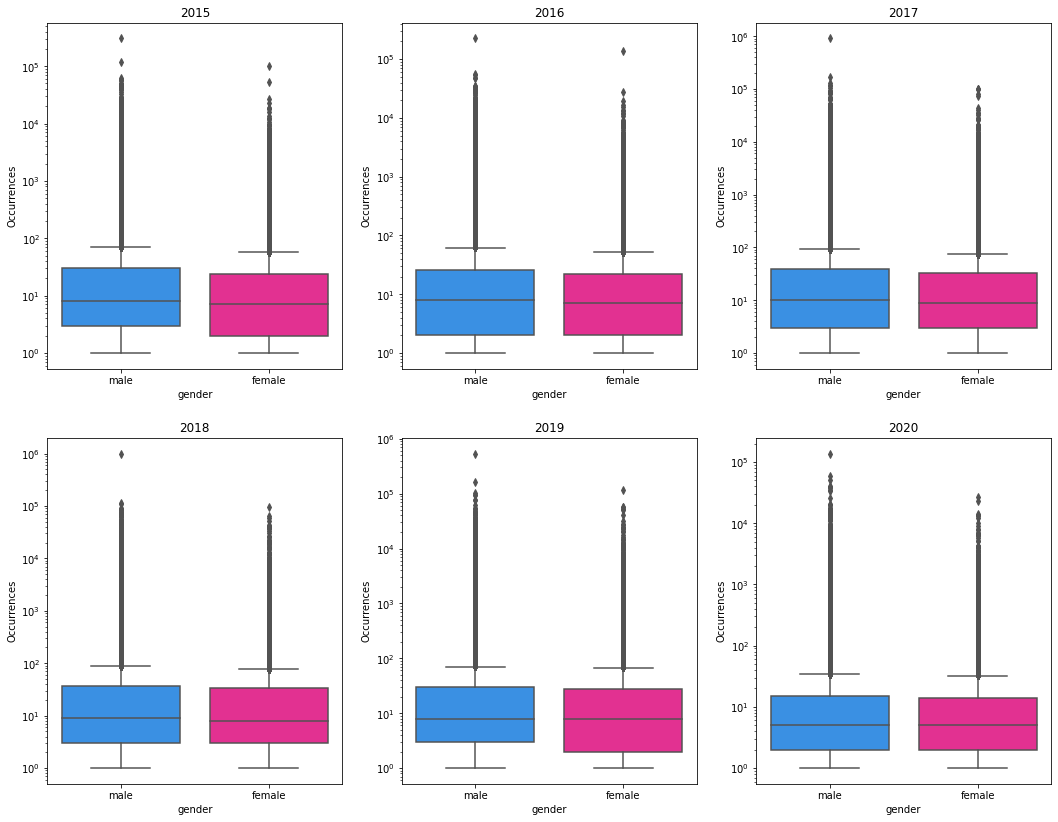

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(18,14))
my_colors = ['dodgerblue', 'deeppink'] 
sns.set_palette( my_colors ) 

for i,ax,year in zip(range(6),axs.flatten(),years) : 
  tab = unique_person[i]
  tab = tab[(tab.gender=="male") | (tab.gender=="female")]
  sns.boxplot(x="gender",y="numOccurrences",data=tab,ax=ax,order=["male","female"])
  ax.set_ylabel("Occurrences")
  ax.set_title(year)
  ax.set_yscale('log')

We choose to present the graph without the outliers and to study the outliers later, to be able to compare the main part of the population together. 

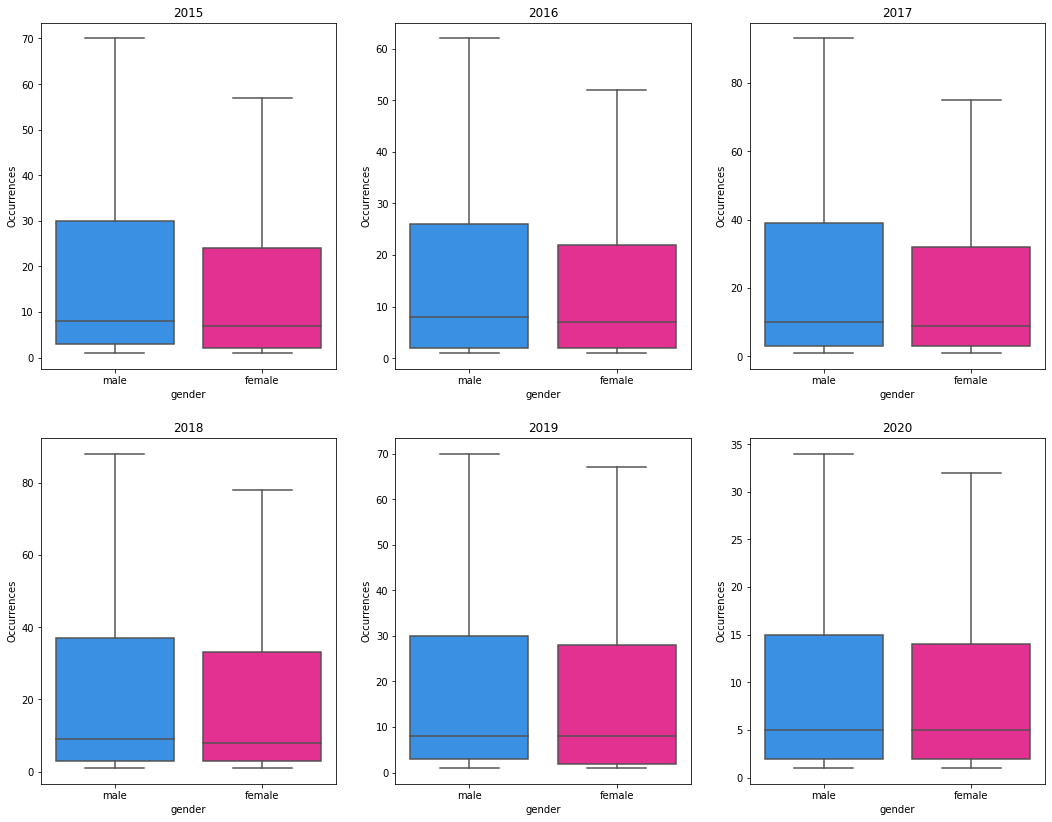

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(18,14))
for i,ax,year in zip(range(6),axs.flatten(),years) : 
  tab = unique_person[i]
  tab = tab[(tab.gender=="male") | (tab.gender=="female")]
  sns.boxplot(x="gender",y="numOccurrences",data=tab,ax=ax,showfliers = False,order=["male","female"])
  ax.set_ylabel("Occurrences")
  ax.set_title(year)


statistics without the outliers:

In [11]:
print("With outliers")
for i,year in zip(range(6),years): 
  tab = unique_person[i]
  male = tab[tab.gender=="male"]
  female = tab[tab.gender=="female"]
  print("{} : {}".format(year,ttest_ind(male['numOccurrences'],female['numOccurrences'])))

With outliers
2015 : Ttest_indResult(statistic=4.83443691903311, pvalue=1.336055248765048e-06)
2016 : Ttest_indResult(statistic=3.4501950381840008, pvalue=0.0005602961295084184)
2017 : Ttest_indResult(statistic=3.4179203603744264, pvalue=0.0006311147603682202)
2018 : Ttest_indResult(statistic=2.5196382641962445, pvalue=0.011748153761544162)
2019 : Ttest_indResult(statistic=1.8063445855618074, pvalue=0.07086584592759798)
2020 : Ttest_indResult(statistic=1.6563798427173229, pvalue=0.09764765852320328)


In [13]:
print("without outliers")
for i,year in zip(range(6),years):
  tab = unique_person[i]
  male = tab[tab.gender=="male"]
  female = tab[tab.gender=="female"] 
  z_male = np.abs(stats.zscore(male.numOccurrences))  #we use the z score to remove outliers of the numOccurrences column
  idx = np.where(z_male<3,True,False)   #we search the index of the z score of the numOccurrences that are below the threshold 3 -> send us True if it's the case
  id = pd.Series(idx,male.index)  #we give to the boolean obtained to its corresponding index
  new_male = male.loc[id==True]    # we keep only the data we a boolean id that is True (z_score<3)

  z_female = np.abs(stats.zscore(female.numOccurrences))
  idx = np.where(z_female<3,True,False)
  id = pd.Series(idx,female.index)
  new_female = female.loc[id==True]

  print("{} : {}".format(year,ttest_ind(new_male['numOccurrences'],new_female['numOccurrences'],alternative='greater')))

without outliers
2015 : Ttest_indResult(statistic=16.081761257154614, pvalue=1.8375022430466088e-58)
2016 : Ttest_indResult(statistic=8.350871052699866, pvalue=3.409184832223569e-17)
2017 : Ttest_indResult(statistic=17.093578892657032, pvalue=9.018008298311393e-66)
2018 : Ttest_indResult(statistic=15.615830479171223, pvalue=3.0118929895339682e-55)
2019 : Ttest_indResult(statistic=8.38377359026447, pvalue=2.577173930286326e-17)
2020 : Ttest_indResult(statistic=6.436874220134217, pvalue=6.121983920966989e-11)


Probability increases with time, specially in the two last years (2019 & 2020) where the difference in means is not statistically significant.

j'ai choisi de retirer les outliers et de regrouper toutes les années pour éviter du multi-testing. après, je veux bien votre avis!

In [ ]:
tab_male=pd.DataFrame()
tab_female=pd.DataFrame()

indexation=[0, 1, 2, 3, 4, 5]
for index in indexation: 
  tab=unique_person[index]
  tab_male = tab_male.append(tab[tab.gender=="male"])
  tab_female = tab_female.append(tab[tab.gender=="female"])

tab_female.head()

,gender,qids,numOccurrences
5,female,Q40757468,757
14,female,Q7563039,140
15,female,Q2227969,429
16,female,Q444685,1807
21,female,Q4755296,744


Pb vis a vis de la version de pandas

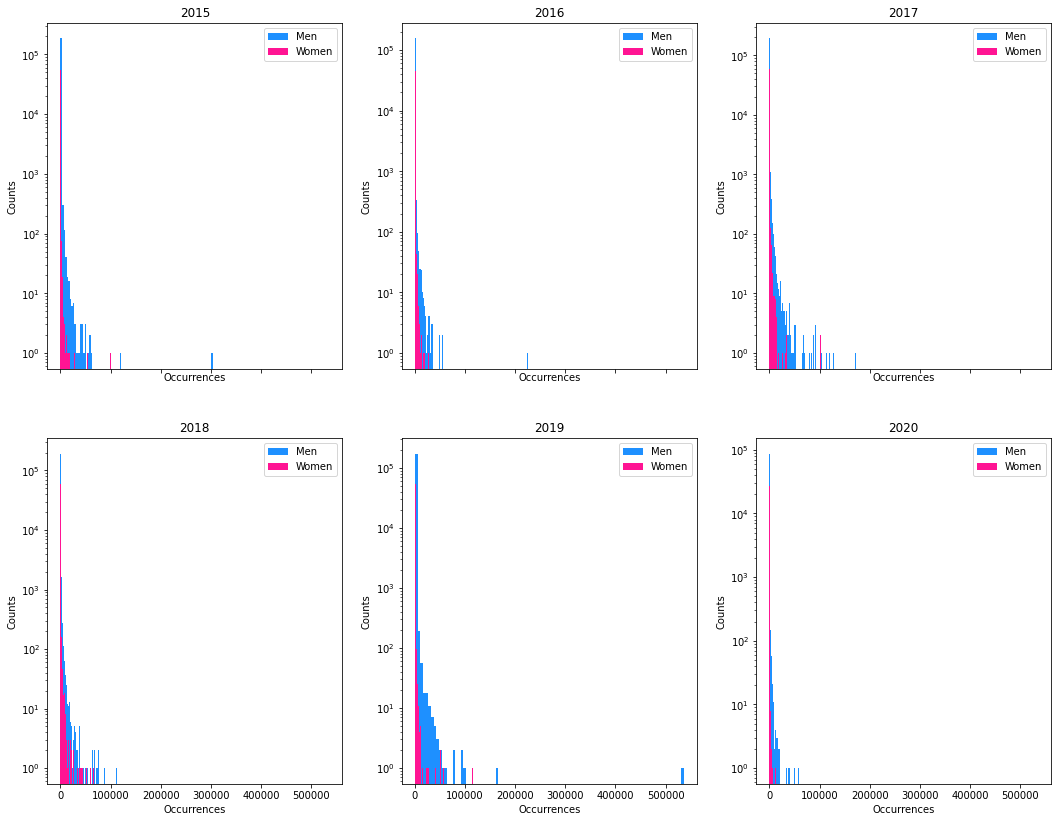

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(18,14), sharex=True)
for i,ax,year in zip(range(6),axs.flatten(),years) : 
  tab = unique_person[i]
  male = tab[tab.gender=="male"]
  male=male[male["numOccurrences"]<0.6e6]

  female = tab[tab.gender=="female"]
  #female['numOccurrences']=female[female["numOccurrences"]<0.6e6]
  ax.hist(male["numOccurrences"],bins=100,histtype='stepfilled',label='Men',color='dodgerblue')
  ax.hist(female["numOccurrences"],bins=100,histtype='stepfilled',label='Women',color='deeppink')
  ax.set_xlabel("Occurrences")
  ax.set_ylabel("Counts")
  ax.set_title(year)
  ax.set_yscale('log')
  ax.legend()


### In terms of proportion of speaker, how many speakers are women and how many are men?

In [ ]:
F=[0]*len(years)
M=[0]*len(years)
for i,year in enumerate(years) : 
  tab = unique_person[i]
  M[i] = len(tab[tab.gender == "male"])
  F[i] = len(tab[tab.gender == "female"])

In [ ]:
total = [x + y for x, y in zip(F, M)]
F_p = [100*x/y for x, y in zip(F, total)]
M_p = [100*x/y for x, y in zip(M, total)]

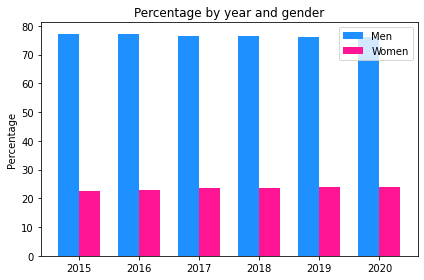

In [ ]:
x = np.arange(len(years))  # the years locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, M_p, width, label='Men',color='dodgerblue')
rects2 = ax.bar(x + width/2, F_p, width, label='Women',color="deeppink")

ax.set_ylabel('Percentage')
ax.set_title('Percentage by year and gender')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

fig.tight_layout()

plt.show()

The percentage of women in the total list of different speakers doesn't seem to change over time. The difference in number of women in the group of speakers could explain alone the data we found at the begining. 

## Political impact


We decided to add the political party attribute from the parquet file to our dataset to include it in our analysis.

In [ ]:
# extracting party
path_parquet = './speaker_attributes.parquet'
parquet = pd.read_parquet(path_parquet)
parquet = parquet[['id', 'party']]

path_label_descriptions = './wikidata_labels_descriptions_quotebank.csv.bz2'
string_data = pd.read_csv(path_label_descriptions, compression='bz2', index_col='QID')
quids_redir = {'Q3268166': 'clinical psychologist', 'Q12014399': 'catholic priest', 'Q11819457': 'visual artist',
               'Q12334852': 'sailor', 'Q3186984': 'journalist', 'Q15991263': 'auctioneer', 'Q12455619': 'social worker',
               'Q1248362': 'director of a creative work', 'Q13365117': 'handball player', 'Q21550646': 'glass painter',
               'Q6363085': 'advocate', 'Q16287483': 'opinion journalist', 'Q13424794': 'computational scientist',
               'Q11815360': 'pediatrician', 'Q5568256': 'forester', 'Q6859927': 'lady-in-waiting', 'Q15145782': 'transgender female',
               'Q15145783': 'transgender male'}

parquet['party'] = parquet['party'].apply(convert_id_str)

parquet.to_pickle('/content/drive/MyDrive/ADA/project/parquet_party_str.pkl')

In [ ]:
# adding party to dataset

years = ['2020', '2019', '2018', '2017', '2016', '2015']
n_chunks = [53, 218, 273, 267, 139, 208]

for i,year in enumerate(years):
    path_to_sfile = '/content/drive/MyDrive/Results/quotes-'+year+'_processed_merged.pkl' 
    path_to_dfile = '/content/drive/MyDrive/Results/quotes-'+year+'_processed_merged_2.pkl' 
  
    with open(path_to_sfile, 'rb') as f:
        for chunk_idx in range(n_chunks[i]):
            chunk = pkl.load(f)
            chunk = chunk.merge(parquet, left_on='qids', right_on='id')
            with open(path_to_dfile, 'ab') as dest: 
                pkl.dump(chunk, dest)

### Loading of the data


In [ ]:
pol_person_2015 = pd.DataFrame()
pol_person_2016 = pd.DataFrame()
pol_person_2017 = pd.DataFrame()
pol_person_2018 = pd.DataFrame()
pol_person_2019 = pd.DataFrame()
pol_person_2020 = pd.DataFrame()
pol_person=[pol_person_2015, pol_person_2016, pol_person_2017, pol_person_2018, pol_person_2019, pol_person_2020]
years = ['2015','2016','2017','2018','2019','2020']
n_chunks = [208, 139, 267, 273, 218, 53]
for index,year in enumerate(years) : 
  path_to_sfile = '/content/drive/MyDrive/Results/quotes-'+year+'_processed_merged_2.pkl'

  unique_chunk = pd.DataFrame()

  with open(path_to_sfile, 'rb') as f:
    for chunk_idx in range(n_chunks[index]):
      chunk = pkl.load(f)
      unique_chunk_new = pd.DataFrame(chunk[["gender","qids", "party", 'numOccurrences']])
      unique_chunk_new = unique_chunk_new.dropna(axis=0)
      unique_chunk = unique_chunk.append(pd.DataFrame(unique_chunk_new))
  pol_person[index] = unique_chunk


In [ ]:
copy=pol_person
party_2015=pd.DataFrame()
party_2016=pd.DataFrame()
party_2017=pd.DataFrame()
party_2018=pd.DataFrame()
party_2019=pd.DataFrame()
party_2020=pd.DataFrame()
data=[party_2015, party_2016, party_2017, party_2018, party_2019, party_2020]

for i in range(6):
  tmp=pd.DataFrame(copy[i])
  tmp=tmp.drop_duplicates("qids")
  tmp=pd.get_dummies(tmp, columns=["gender"])
  tmp=tmp[["qids", "party","gender_female","gender_male"]]
  tmp.party = tmp.party.apply(lambda x : x[0])  #we need to remove the [] surrounding the party name to do the groupby
  tmp=tmp.groupby("party",as_index=False)[["gender_female","gender_male"]].agg("sum")
  data[i]=tmp

### Study of the ten more quoted parties of the dataset

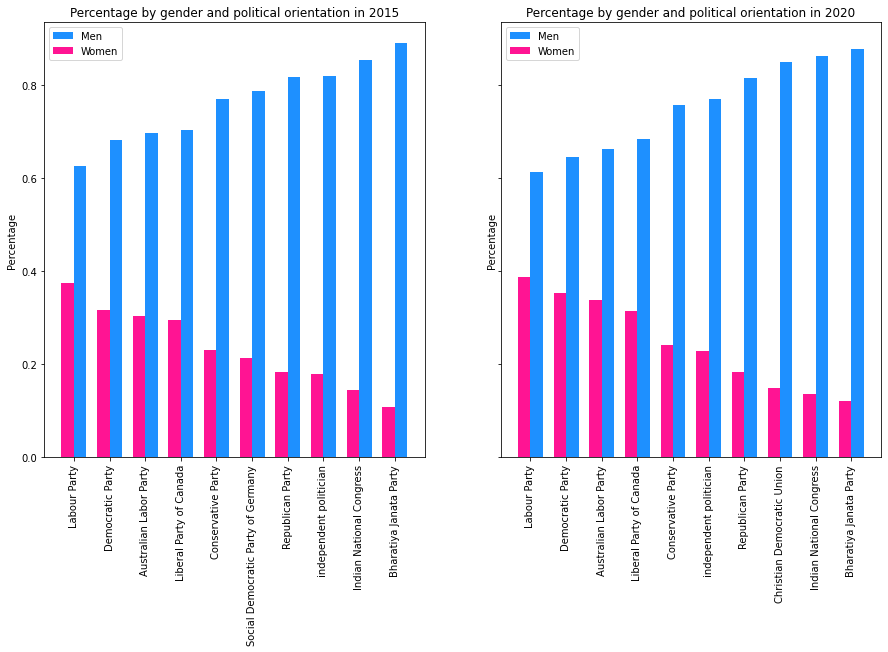

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,8), sharey=True)
age=np.linspace(0, 100, 101)
width = 0.35
years=[2015,2020]
nb=[0,5]

for i, ax, year in zip(nb,axs.flatten(),years) :
  tmp=data[i] 
  tmp["percentage_male"] = (tmp['gender_male']/(tmp['gender_male']+tmp['gender_female']))
  tmp["percentage_female"] = (tmp['gender_female']/(tmp['gender_male']+tmp['gender_female']))
  tmp["total_speaker"] = tmp['gender_male']+tmp['gender_female']
  tmp=tmp.sort_values("total_speaker", ascending=False)
  ten_best=tmp.iloc[0:10,]
  ten_best=ten_best.sort_values("percentage_female", ascending=False)
  label=ten_best.party.values.tolist()
  x = np.arange(len(ten_best.party))
  ax.bar(x+width/2, ten_best.percentage_male, width, label='Men',color='dodgerblue')
  ax.bar(x-width/2, ten_best.percentage_female, width, label='Women',color="deeppink")
  ax.set_ylabel('Percentage') 
  ax.set_title('Percentage by gender and political orientation in ' + str(year))
  ax.set_xticks(x)
  ax.set_xticklabels(label,rotation="vertical")
  ax.legend()


## Age impact

### Loading of the data

In [39]:
age_person_2015 = pd.DataFrame()
age_person_2016 = pd.DataFrame()
age_person_2017 = pd.DataFrame()
age_person_2018 = pd.DataFrame()
age_person_2019 = pd.DataFrame()
age_person_2020 = pd.DataFrame()
age_person=[age_person_2015, age_person_2016, age_person_2017, age_person_2018, age_person_2019, age_person_2020]
years = ['2015','2016','2017','2018','2019','2020']
n_chunks = [208, 139, 267, 273, 218, 53]
for index,year in enumerate(years) : 
  path_to_sfile = '/content/drive/MyDrive/Results/quotes-'+year+'_processed_merged.pkl'

  unique_chunk = pd.DataFrame()

  with open(path_to_sfile, 'rb') as f:
    for chunk_idx in range(n_chunks[index]):
      chunk = pkl.load(f)
      unique_chunk_new = chunk[["gender","qids", 'date_of_birth','numOccurrences']]
      unique_chunk = unique_chunk.append(pd.DataFrame(unique_chunk_new)).drop_duplicates(subset="qids")
  age_person[index] = unique_chunk

In [40]:
years=[2015, 2016, 2017, 2018, 2019, 2020]
index=[0, 1, 2, 3, 4, 5]
copy= np.zeros((6, 1))
for data, year, i in zip(age_person, years, index): 
  data['age']= year - (data['date_of_birth'].astype(int))
  data = data[data.age > 0]


In [ ]:
for data, year, i in zip(age_person, years, index): 
  print("{} : {}".format(year,data[data.age<0]))

2015 :        gender       qids date_of_birth  numOccurrences  age
24339    male  Q38668629         +2018               1   -3
17063    male  Q16727574         +2021               1   -6
19100  female  Q23907172         +2020               1   -5
2016 :       gender       qids date_of_birth  numOccurrences  age
16152   male  Q16727574         +2021               1   -5
2017 :        gender       qids date_of_birth  numOccurrences  age
25629    male  Q16727574         +2021               1   -4
25967    male  Q38668629         +2018               1   -1
25128  female  Q23907172         +2020               1   -3
2018 :        gender       qids date_of_birth  numOccurrences  age
18804  female  Q23907172         +2020               1   -2
2019 :        gender       qids date_of_birth  numOccurrences  age
11739  female  Q23907172         +2020               2   -1
24403    male  Q16727574         +2021               1   -2
2020 : Empty DataFrame
Columns: [gender, qids, date_of_birth, numOc

In [41]:
female_2015=pd.DataFrame()
female_2016=pd.DataFrame()
female_2017=pd.DataFrame()
female_2018=pd.DataFrame()
female_2019=pd.DataFrame()
female_2020=pd.DataFrame()

data_female=[female_2015, female_2016, female_2017, female_2018, female_2019, female_2020]
data_male=[female_2015, female_2016, female_2017, female_2018, female_2019, female_2020]


for data, year, i in zip(age_person, years, range(6)): 
  data_female[i]=data[data['gender']=='female']
  index = np.linspace(0, len(data_female[i])-1, len(data_female[i]))
  data_female[i]=data_female[i].set_index(index)

  data_male[i]=data[data['gender']=='male']
  index=np.linspace(0, len(data_male[i])-1, len(data_male[i]))
  data_male[i]=data_male[i].set_index(index)

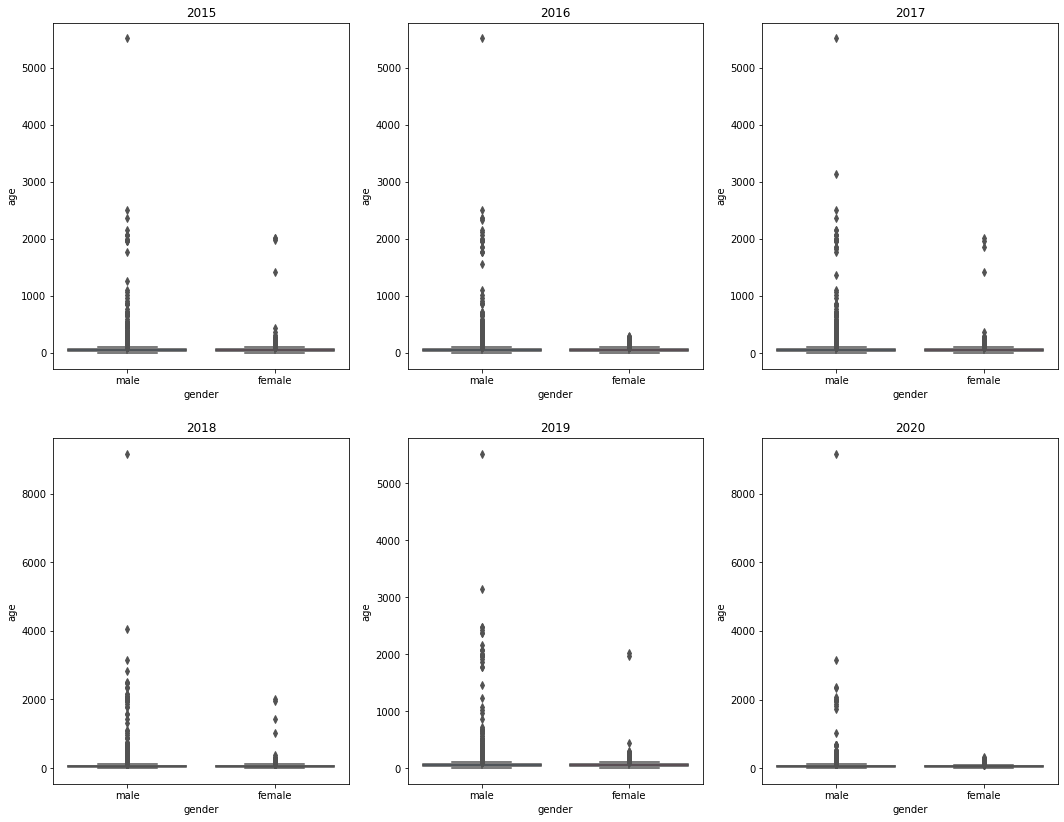

In [45]:
fig, axs = plt.subplots(2,3, figsize=(18,14))
my_colors = ['dodgerblue', 'deeppink'] 
sns.set_palette( my_colors ) 

for i,ax,year in zip(range(6),axs.flatten(),years) : 
  tab=age_person[i]
  tab = tab[tab.age > 0]
  tab = tab[(tab.gender=="male") | (tab.gender=="female")]
  sns.boxplot(x="gender",y="age",data=tab,ax=ax,order=["male","female"])
  ax.set_ylabel("age")
  ax.set_title(year)


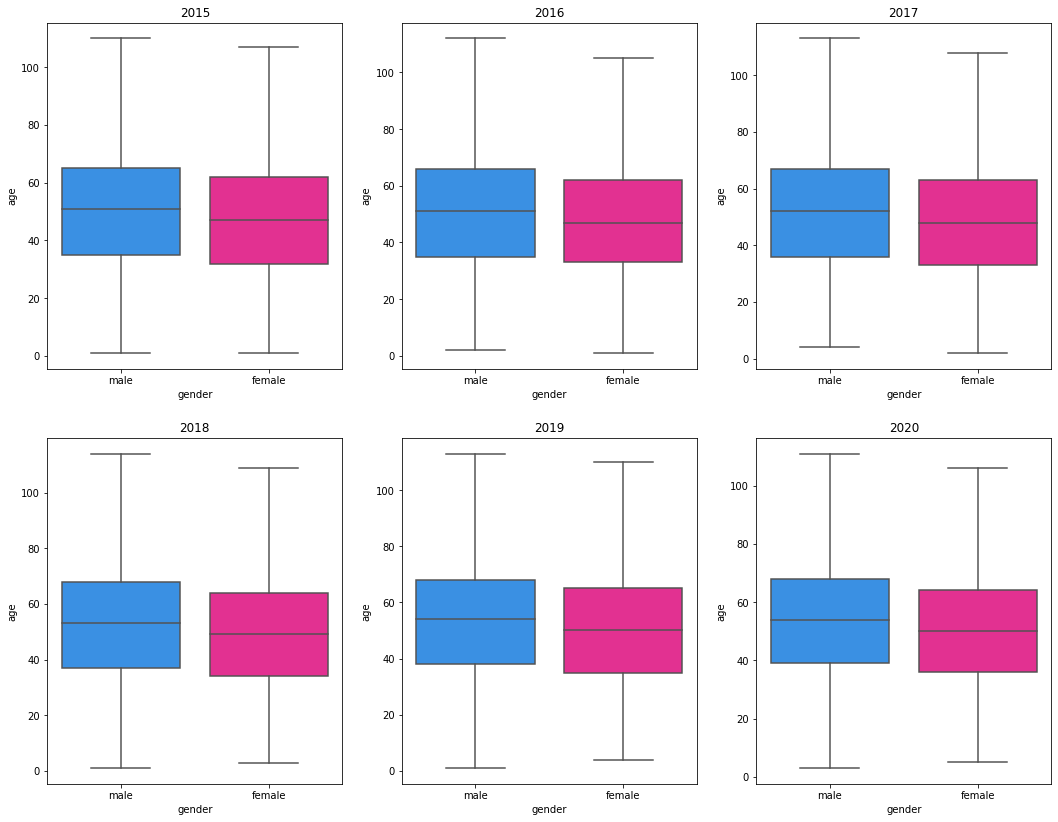

In [44]:
fig, axs = plt.subplots(2,3, figsize=(18,14))
my_colors = ['dodgerblue', 'deeppink'] 
sns.set_palette( my_colors ) 

for i,ax,year in zip(range(6),axs.flatten(),years) : 
  tab=age_person[i]
  tab = tab[tab.age > 0]
  tab = tab[(tab.gender=="male") | (tab.gender=="female")]
  sns.boxplot(x="gender",y="age",data=tab,ax=ax,order=["male","female"], showfliers = False)
  ax.set_ylabel("age")
  ax.set_title(year)


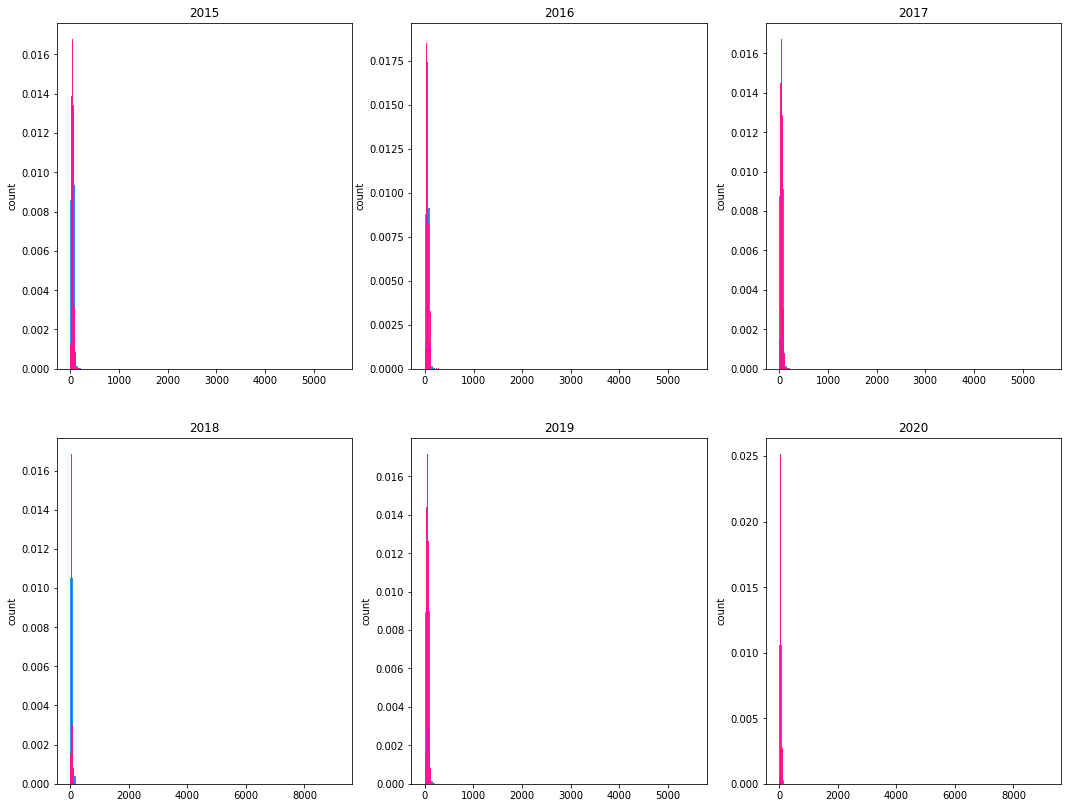

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(18,14))
age=np.linspace(0, 100, 101)

for i,ax,year in zip(range(6),axs.flatten(),years) : 
  tab_male=data_male[i]
  tab_female=data_female[i]
  ax.hist(bins=100,  density=True, x=tab_male['age'], color= 'dodgerblue')
  ax.hist( bins=100,density=True, x=tab_female['age'], color='deeppink')
  ax.set_ylabel("count")
  ax.set_title(year)

##fig.title('Distribution of occurence of speak between men and women according to their age');


### Study of the speakers that are alive

We choose that under the age of 100, the speaker could be consider as alive, and here, we only want to study the repartition of alive speakers. 

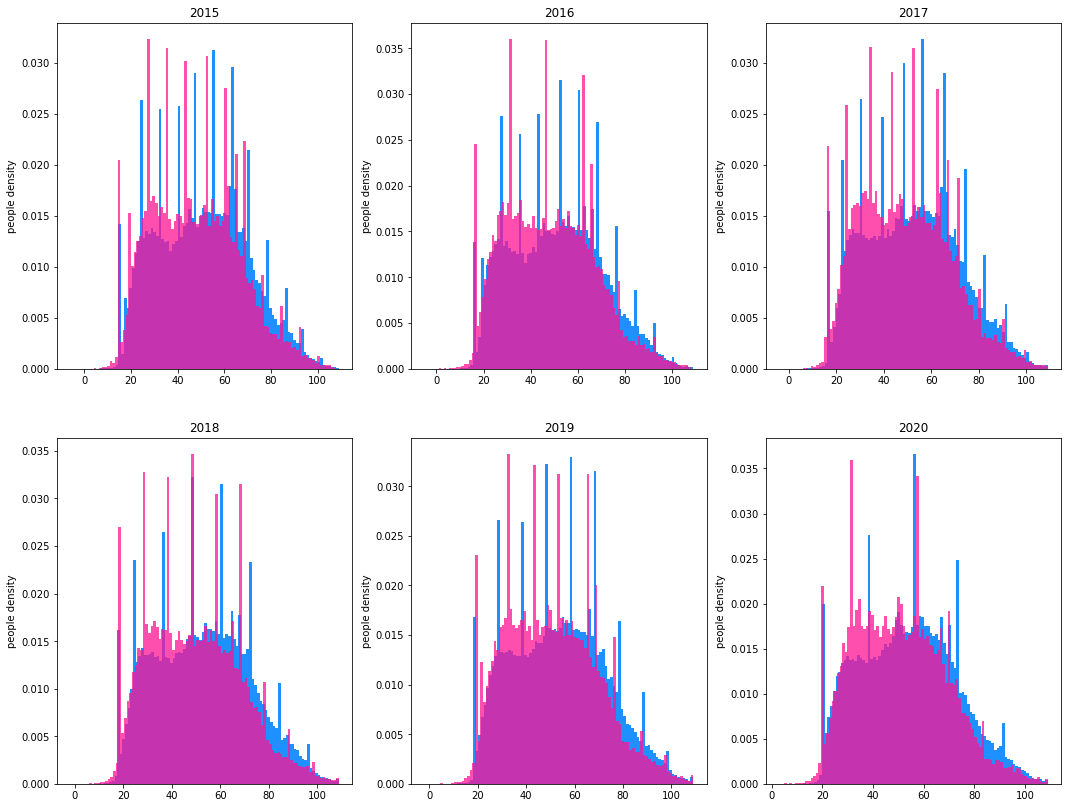

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(18,14))

for i,ax,year in zip(range(6),axs.flatten(),years) : 
  tab_male=data_male[i]
  tab_male=tab_male[tab_male.age<100]
  tab_female=data_female[i]
  tab_female=tab_female[tab_female.age<100]
  ax.hist(bins=100, density=True, x=tab_male['age'], color= 'dodgerblue')
  ax.hist( bins=100,density=True, x=tab_female['age'], color='deeppink', alpha=0.75)
  ax.set_ylabel("people density")
  ax.set_title(year)

##fig.title('Distribution of occurence of speak between men and women according to their age');

We perform a one-side ttest to assess whether the difference we could visualy observe on the graph is statistically significant. 
We perform a one-side ttest to get higher power, and because we don't only want to prove that the mean are different but that there is indeed one mean higher than the other.

In [ ]:
data_male_0=data_male[0]
tab_male=pd.DataFrame(data_male_0[data_male_0.age<100])
data_female_0=data_female[0]
tab_female=pd.DataFrame(data_female_0[data_female_0.age<100])

for i in range(1, 6): 
  tab_male_1=data_male[i]
  tab_male=tab_male.append(tab_male_1[tab_male_1.age<100])
  tab_female_1=data_female[i]
  tab_female=tab_female=tab_female_1[tab_female_1.age<100]

ttest_ind(tab_male['age'],tab_female['age'], alternative='greater')


Ttest_indResult(statistic=14.226889633773494, pvalue=3.152108198552272e-46)

The pvalue is really small, so we can conclude that there is statistically significant difference between the age repartition of the men and the one of the women. 

### Study of the people that are dead

In [ ]:
for i in range (6):
  data_female_dead=data_female[i]
  data_female_dead=data_female_dead[data_female_dead['age']>100]
  data_male_dead=data_male[i]
  data_male_dead=data_male_dead[data_male_dead['age']>100]
  print('number of dead women quoted: {}'.format(len(data_female_dead)))
  print('number of dead men quoted: {}'.format(len(data_male_dead)))

number of dead women quoted: 621
number of dead men quoted: 1852
number of dead women quoted: 536
number of dead men quoted: 1548
number of dead women quoted: 654
number of dead men quoted: 1941
number of dead women quoted: 662
number of dead men quoted: 1990
number of dead women quoted: 590
number of dead men quoted: 1765
number of dead women quoted: 277
number of dead men quoted: 846


These results are funny, because the repartition of the speakers is close to the one we have nowadays, even though we have the historical bias (men were more represented and were more public figures than women).

## Occupations

We want to group the occupations of the speakers in our dataset into more generic categories. To this end, we use the Wikidata dumps (wikidata-20211129-all.json.gz) to go up in the occupation tree, i.e. by getting the attribute "subclass of" of all the occupations in our dataset. This process is repeated four times, i.e. we go up four levels up in the tree to be sure to extract the top level categories, even for specific occupations (e.g. clinical pharmacologist -> clinician -> medical specialist -> physician -> health professional). Since we are missing the labels for the last level category, we use the provided file wikidata_labels_descriptions.csv.bz2 to get them.

In [ ]:
# df4 is the result of the last parsing of the wiki dump
df4 = pd.read_json('./data/occupation_categories4.json', lines=True)
df4.rename(columns={'id':'category3_id','label':'category3_label','occupation_cat':'category4_id'}, inplace=True)
df4.loc[df4.category4_id.notna(), 'category4_id'] = df4.loc[df4.category4_id.notna(), 'category4_id'].apply(lambda x: x[0])
df4.sample(5)

,category3_id,category3_label,category4_id
613,Q628523,message,Q11028
99,Q23498,archaeology,Q1066186
452,Q3391743,visual artist,Q483501
141,Q1414937,combatant,Q215627
510,Q82594,computer scientist,Q5157565


In [ ]:
# convert (one) wiki id to string
def convert_id_str2(x):
  # id needs to be in string_data index otherwise error    
  try:
    string = string_data.loc[x, 'Label']
  except KeyError:
    #print('Id: {} was not found in label_descriptions'.format(id))
    if x in quids_redir.keys():
      string = quids_redir[x]
    else:
      string = None
  return string

path_label_descriptions = './data/wikidata_labels_descriptions.csv.bz2'
df_reader = pd.read_csv(path_label_descriptions, compression='bz2', index_col='QID', chunksize=10000000) 
init=True
for string_data in df_reader: 
  if init:
    tmp = df4.category4_id.notna()
    init=False
  else:
    tmp = df4.category4_id.notna() & df4.category4_label.isnull()
  df4.loc[tmp, 'category4_label'] = df4.loc[tmp, 'category4_id'].apply(convert_id_str2)

We had four dataframes with the same structure as df4 above, one for each of the levels of the occupation tree. 
We finally obtain the following dataframe by merging all of them.

In [ ]:
with open('./data/all_categories.pkl', 'rb') as f:
    dfall = pkl.load(f)
dfall

,occupation_id,category_id,occupation_label,category_label,category2_id,category2_label,category3_id,category3_label,category4_id,category4_label
0,Q75,Q1068715,Internet,telecommunications network,Q1900326,network,Q58778,system,Q6671777,structure
1,Q362,NaN,World War II,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Q431,Q420,zoology,biology,Q7991,natural science,Q336,science,Q58778,system
3,Q514,Q420,anatomy,biology,Q7991,natural science,Q336,science,Q58778,system
4,Q676,Q7725634,prose,literary work,Q47461344,written work,Q17537576,creative work,Q15621286,intellectual work
...,...,...,...,...,...,...,...,...,...,...
12553,Q106201355,Q30002353,Esperanto teacher,language teacher,Q37226,teacher,Q974144,educator,Q20826540,erudite
12554,Q106201362,Q482980,Gesakusha,author,Q2500638,creator,Q702269,professional,Q215627,person
12555,Q106211908,NaN,morin khuur player,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12556,Q106230599,Q5133860,clinical pharmacologist,clinician,Q3332438,medical specialist,Q39631,physician,Q11974939,health professional


Even if we went up by four levels, we still have a large variety of top-level categories, so we decide to group them into 11 categories : armed forces, arts, business, civil service, education & studies, legal professionals, manual work, politics, religion, science & technology and sports. With the help of wikidata and the dataframe previoulsy constructed, we define a set of labels that correspond to each category, e.g. for sports the labels are sportsperson, athlete and sport.

In [ ]:
# determine final category based on extracted labels for each occupation
def final_category(occupations):
    occupations = list(occupations)[1:] # remove index
    nlabels_present = {}
    # politics: 'politician', 'statesperson', 'head of government', 'senior government officials', 'ruler', 'public office', 'minister'
    politics = ['Q82955', 'Q372436', 'Q2285706', 'Q108290289', 'Q1097498', 'Q294414', 'Q83307']
    if any(item in politics for item in occupations):
        nlabels_present['politics'] = ((np.array(occupations).reshape(-1,1)==np.array(politics).reshape(1,-1)).any(axis=1)).sum()
    #business: 'businessperson', 'executive', 'entrepreneur', 'manager'
    business = ['Q43845', 'Q978044', 'Q131524', 'Q2462658']
    if any(item in business for item in occupations):
        nlabels_present['business'] = ((np.array(occupations).reshape(-1,1)==np.array(business).reshape(1,-1)).any(axis=1)).sum()
    # arts: 'artist', 'creator', 'creative work', 'art', 'instrumentalist', 'art of painting'
    arts = ['Q483501', 'Q2500638', 'Q17537576', 'Q735', 'Q1278335', 'Q11629']
    if any(item in arts for item in occupations):
        nlabels_present['arts'] = ((np.array(occupations).reshape(-1,1)==np.array(arts).reshape(1,-1)).any(axis=1)).sum()
    #sports: 'sportsperson', 'athlete', 'sport'
    sports = ['Q50995749', 'Q2066131', 'Q349']
    if any(item in sports for item in occupations):
        nlabels_present['sports'] = ((np.array(occupations).reshape(-1,1)==np.array(sports).reshape(1,-1)).any(axis=1)).sum()
    # science&tech: 'physician', 'computer scientist', 'health professional', 'scientist', 'science', 'researcher', 'engineer', 'technician'
    science_tech = ['Q39631', 'Q82594', 'Q11974939', 'Q901', 'Q336', 'Q1650915', 'Q81096', 'Q5352191']
    if any(item in science_tech for item in occupations):
        nlabels_present['science & technology'] = ((np.array(occupations).reshape(-1,1)==np.array(science_tech).reshape(1,-1)).any(axis=1)).sum()
    # religion: 'cleric', 'believer', 'religious leader', 'religious', 'monk', 'minister'
    religion = ['Q2259532', 'Q17573152', 'Q15995642', 'Q2566598', 'Q733786', 'Q1423891']
    if any(item in religion for item in occupations):
        nlabels_present['religion'] = ((np.array(occupations).reshape(-1,1)==np.array(religion).reshape(1,-1)).any(axis=1)).sum()
    # armed_forces: 'military personnel', 'warrior', 'combatant', 'military position'
    armed_forces = ['Q47064', 'Q1250916', 'Q1414937', 'Q16631188'] 
    if any(item in armed_forces for item in occupations):
        nlabels_present['armed forces'] = ((np.array(occupations).reshape(-1,1)==np.array(armed_forces).reshape(1,-1)).any(axis=1)).sum()
    # civil_service: 'civil servant', 'public employee', 'activist', 'diplomat'
    civil_service = ['Q212238', 'Q80363469', 'Q15253558', 'Q193391'] 
    if any(item in civil_service for item in occupations):
        nlabels_present['civil service'] = ((np.array(occupations).reshape(-1,1)==np.array(civil_service).reshape(1,-1)).any(axis=1)).sum()
    #legal_professionals: 'legal professionals', 'jurist', 'person linked to the law'
    legal_professionals = ['Q108289403', 'Q185351', 'Q57735705'] 
    if any(item in legal_professionals for item in occupations):
        nlabels_present['legal professionals'] = ((np.array(occupations).reshape(-1,1)==np.array(legal_professionals).reshape(1,-1)).any(axis=1)).sum()
    # manual_work: 'artisan', 'manual worker' 
    manual_work = ['Q1294787', 'Q12713481'] 
    if any(item in manual_work for item in occupations):
        nlabels_present['manual work'] = ((np.array(occupations).reshape(-1,1)==np.array(manual_work).reshape(1,-1)).any(axis=1)).sum()
    # education&studies: 'teacher', 'academic professional', 'academic', 'erudite person', 'teaching professionals'
    education_studies = ['Q37226', 'Q66666685', 'Q3400985', 'Q20826540', 'Q108284914']
    if any(item in education_studies for item in occupations):
        nlabels_present['education & studies'] = ((np.array(occupations).reshape(-1,1)==np.array(education_studies).reshape(1,-1)).any(axis=1)).sum()
    
    if len(nlabels_present) > 0:
        # in case an occupation matched with several categories, take category with most matches
        return max(nlabels_present, key=nlabels_present.get)
    else:
        return None

In [ ]:
with open('./data/all_categories_qid.pkl', 'rb') as f: # same as all_categories but only with wiki ids
    df = pkl.load(f)

df['category_final'] = [final_category(row) for row in df.itertuples()]

with open('./data/occupation_categories_ids_final.pkl', 'wb') as f:
    tmp = df.loc[df.category_final.notna(), ['occupation_id', 'category_final']]
    pkl.dump(tmp, f)

This grouping results in the following dataframe, mapping an occupation to one of the 11 categories (or None if unable to determine).

In [ ]:
with open('./data/occupation_categories_ids_final.pkl', 'rb') as f:
    df = pkl.load(f)
df

,occupation_id,category_final
2,Q431,science & technology
3,Q514,science & technology
4,Q676,arts
5,Q901,science & technology
7,Q1455,sports
...,...,...
12551,Q105696682,sports
12553,Q106201355,education & studies
12554,Q106201362,arts
12556,Q106230599,science & technology


Now we can use this dataframe to map the list of occupations of each speaker in our dataset to a list of categories, consequently adding a column 'category_final' to our dataset. With this new column, we will be able to group by categories and see the distribution of women and men according to them. Note that a speaker with several occupations giving different categories will be counted several times.

In [ ]:
def add_final_category(chunk, path_to_dfile, occupation_categories):
    chunk2 = chunk.set_index('quoteID')
    # use occupation ids instead of labels in case different occupations have same label (e.g. minister)
    series = chunk2.occupation2
    # put occupations of each speaker on different cols (same row)
    df = pd.DataFrame(series.tolist(), index=series.index)
    # stack all the columns into a single one (NaNs are dropped)
    df = pd.DataFrame(df.stack(), columns=['occupation_id'])
    df['quoteID'] = df.index.get_level_values('quoteID') 
    df['occupation_number'] = df.index.get_level_values(1)
    # merge with occupation_categories to get categories
    df = df.merge(occupation_categories, on='occupation_id', how='left')
    # group category_final of speaker of each quote and put them in a list
    # gives a 1-col DataFrame with quoteID in index and list of categories in col
    df = df.sort_values(by=['quoteID', 'occupation_number']).groupby('quoteID')['category_final'].agg(list)
    df = pd.DataFrame(df, columns=['category_final'])
    # add list of categories to each quote
    chunk = chunk.merge(df, how='left', left_on='quoteID', right_index=True)
    # occupation ids not needed anymore
    chunk.drop(columns=['occupation2'], inplace=True)

    # save
    with open(path_to_dfile, 'ab') as f:
        pkl.dump(chunk, f)
    
    # category_final can be None or list (which can contain Nones)
    # speakers not used will be those having None or a list full of Nones
    tmp = chunk.loc[chunk.category_final.notna(), 'category_final'].apply(lambda x: list(set(x))[0] 
                                                                          if len(set(x))==1 else 'ok').isnull()
    unused_qids = (chunk.loc[chunk.category_final.isnull(), 'qids'].tolist() + 
                  chunk[chunk.category_final.notna()].loc[tmp, 'qids'].tolist())
    
    return (chunk[['numOccurrences','gender', 'category_final']], unused_qids)

In [ ]:
# extract number of males and females in each category
def extract_genders_per_categories(df0):
    # remove genders other than male/female
    df = df0[(df0.gender=='male') | (df0.gender=='female')].copy()
    # remove duplicates in categories list (in case different occupations gave same category)
    df.loc[df.category_final.notna(), 'category_final'] = df.loc[df.category_final.notna(),
                                                                 'category_final'].apply(lambda x: list(set(x)))
    # extend list of categories with numOccurrences to account for multiple occurrences
    df.category_final = df.numOccurrences * df.category_final
    df.set_index('gender', inplace=True)
    df = df[df.category_final.notna()]
    # put categories of each speaker on different cols (same row)
    df = pd.DataFrame(df.category_final.tolist(), index=df.index)
    # stack all the columns into a single one (NaNs are dropped)
    df = pd.DataFrame(df.stack(), columns=['category_final'])
    df['gender'] = df.index.get_level_values('gender')
    df.reset_index(drop=True, inplace=True)

    #group by category and count number of males and females
    gender_per_cat = pd.DataFrame(df.groupby('category_final')['gender'].value_counts()).rename(
                                                                                         columns={'gender':'counts'})
    # reshape gender_per_cat to have two columns female and male for each category (index)
    gender_per_cat.reset_index(level=1, inplace=True)
    gender_per_cat['male'] = gender_per_cat.loc[gender_per_cat.gender=='male','counts']
    gender_per_cat['female'] = gender_per_cat.loc[gender_per_cat.gender=='female','counts']
    gender_per_cat.drop(columns=['gender', 'counts'], inplace=True)
    gender_per_cat = gender_per_cat[~gender_per_cat.index.duplicated(keep='first')]
    # categories with no females or no males will have nan value -> replace by 0
    gender_per_cat = gender_per_cat.fillna(0)

    return gender_per_cat

In [ ]:
# adding occupation categories and extracting genders per category 

path_parquet = './data/peaker_attributes.parquet'
parquet = pd.read_parquet(path_parquet)
parquet = parquet[['id', 'occupation']].rename(columns={'id':'qids','occupation':'occupation2'})

years = ['2020', '2019', '2018', '2017', '2016', '2015']
n_chunks = [53, 218, 273, 267, 139, 208]

speakers = [[]]*len(years)
speakers_unused = [[]]*len(years)

categories = ['armed forces', 'arts', 'business', 'civil service', 'education & studies', 
              'legal professionals', 'manual work', 'politics', 'religion', 'science & technology', 'sports']

# load DataFrame mapping occupations ids to categories
with open('./data/occupation_categories_ids_final.pkl', 'rb') as f:
    occupation_categories = pkl.load(f)


for i,year in enumerate(years):
    path_to_sfile = './data/quotes-'+year+'_processed_merged_2.pkl' 
    path_to_dfile = './data/quotes-'+year+'_processed_3.pkl'
    path_to_dfile2 = './data/genders_per_categories-'+year+'.pkl'

    # DataFrame to keep track of counts of males/females per category (one for each year)
    df_f = pd.DataFrame(columns=['male', 'female'], index=categories)
    df_f.fillna(0, inplace=True) 

    with open(path_to_sfile, 'rb') as f:
        for chunk_idx in range(n_chunks[i]):
            chunk = pkl.load(f)
            # add occupations ids from parquet file as they were removed for milestone2
            chunk = chunk.merge(parquet, how='left', on='qids')
            # forgot to remove id_x, id_y in chunk from previous merges, done here
            chunk.drop(columns=['id_x', 'id_y'], inplace=True)
            speakers[i] = list(set(speakers[i] + chunk.qids.tolist()))
            gender_and_occupation, unused_qids = add_final_category(chunk, path_to_dfile, occupation_categories)
            speakers_unused[i] = list(set(speakers_unused[i] + unused_qids))
            tmp = extract_genders_per_categories(gender_and_occupation)
            # accumulate counts - use index in case some categories were absent in chunk
            df_f.loc[tmp.index] = df_f.loc[tmp.index] + tmp

    with open(path_to_dfile2, 'wb') as f2:
        pkl.dump(df_f, f2)
        
    n_total = len(speakers[i])
    n_used = n_total - len(speakers_unused[i])
    ratio = n_used / n_total
        
    print('Occupations: year {}: speakers used: {} speakers total: {} ratio: {:.3f}'.format(year, n_used, 
                                                                                            n_total, ratio))

The following is a screenshot of the prints produced by the above cell.
![print_occs](./images/print_occs.png)

Here is an example of the dataframes produced by the above cell:

In [ ]:
with open('./data/genders_per_categories-2020.pkl', 'rb') as f:
    df = pkl.load(f)
df

,male,female
armed forces,156893,4212
arts,1032755,366001
business,621289,105030
civil service,274781,63911
education & studies,300226,79408
legal professionals,558655,167769
manual work,22838,2585
politics,1772643,490666
religion,50650,2016
science & technology,470615,119770


### Percentages of occupations by gender and by occupations themselves

In [46]:
female_occ_2015=pd.DataFrame()
female_occ_2016=pd.DataFrame()
female_occ_2017=pd.DataFrame()
female_occ_2018=pd.DataFrame()
female_occ_2019=pd.DataFrame()
female_occ_2020=pd.DataFrame()

data_female_occ=[female_occ_2015, female_occ_2016, female_occ_2017, female_occ_2018, female_occ_2019, female_occ_2020]
data_male_occ=[female_occ_2015, female_occ_2016, female_occ_2017, female_occ_2018, female_occ_2019, female_occ_2020]
years = ['2015','2016','2017','2018','2019','2020']

for year, i in zip(years, range(6)): 
  path_to_sfile = '/content/drive/MyDrive/Results/genders_per_categories-'+year+'.pkl'

  with open(path_to_sfile,'rb') as f : 
    rrr = pkl.load(f)
    data_female_occ[i] = rrr["female"]
    data_male_occ[i] = rrr["male"]

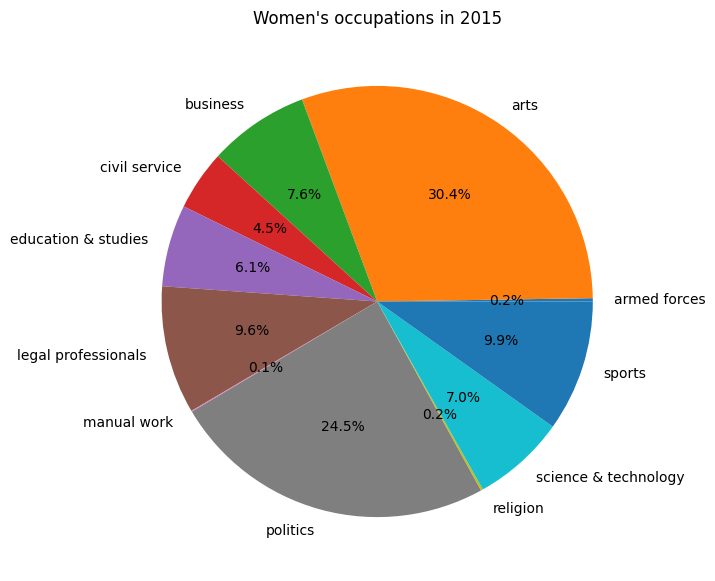

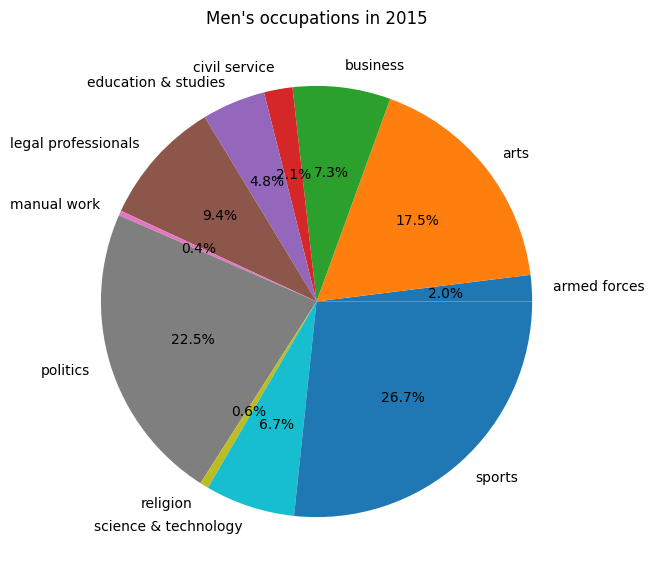

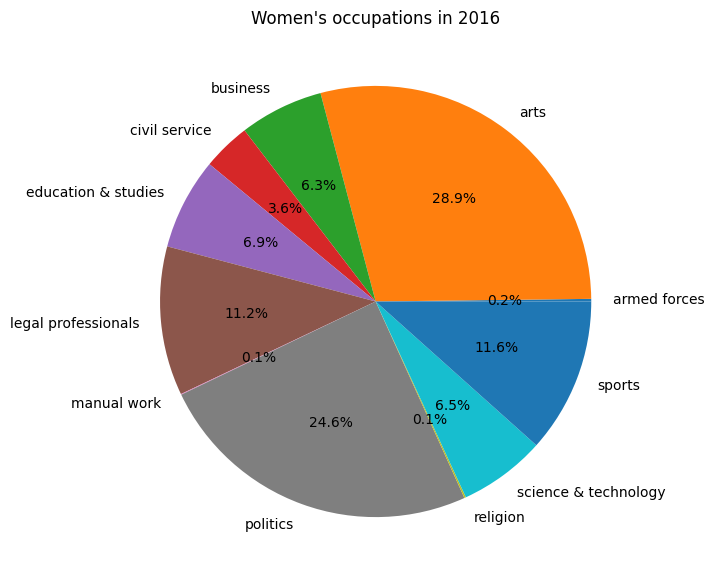

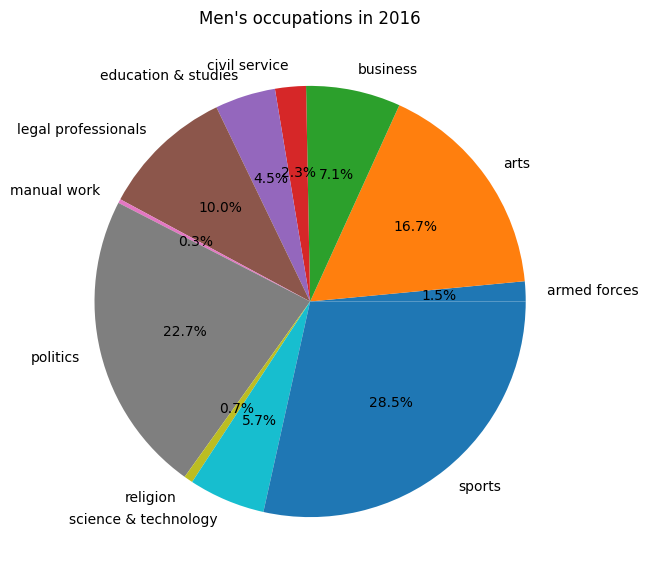

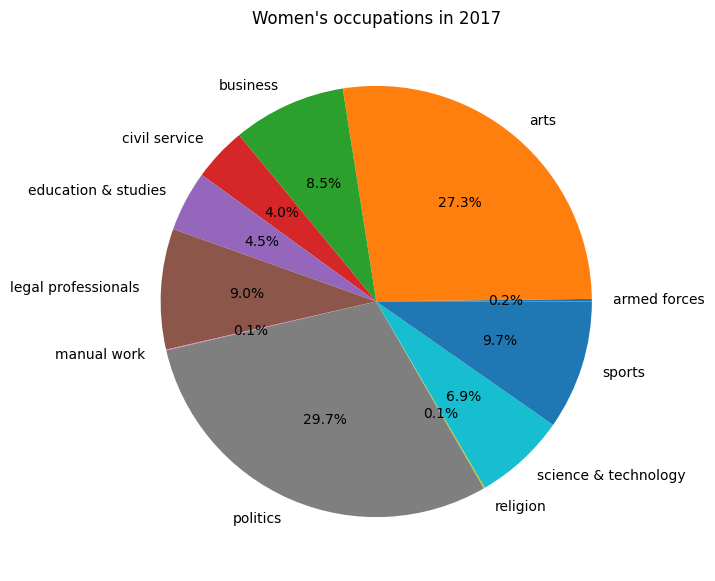

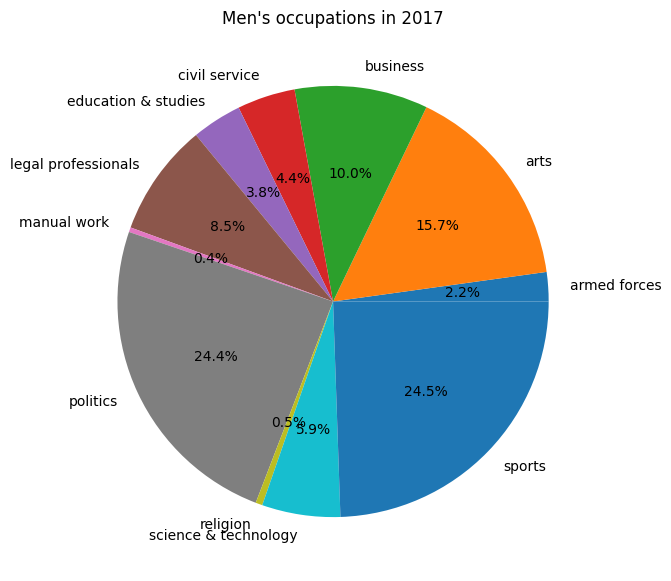

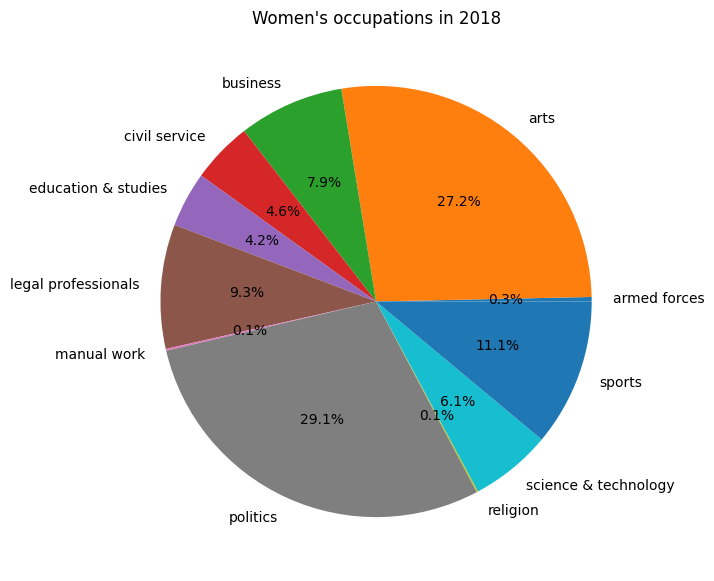

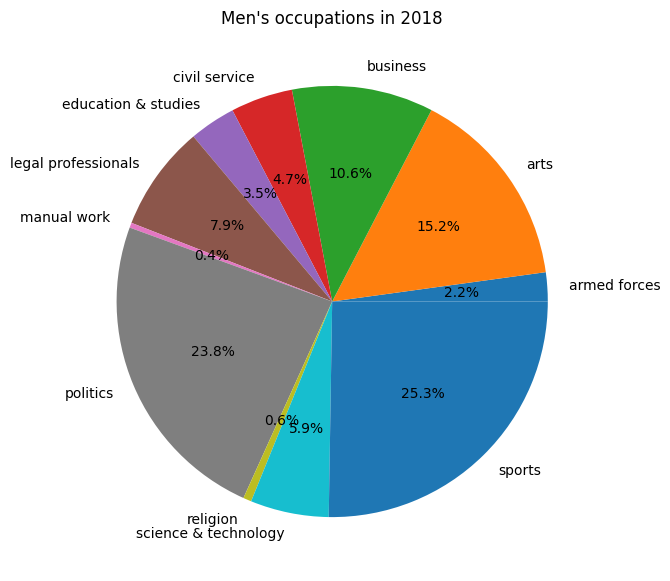

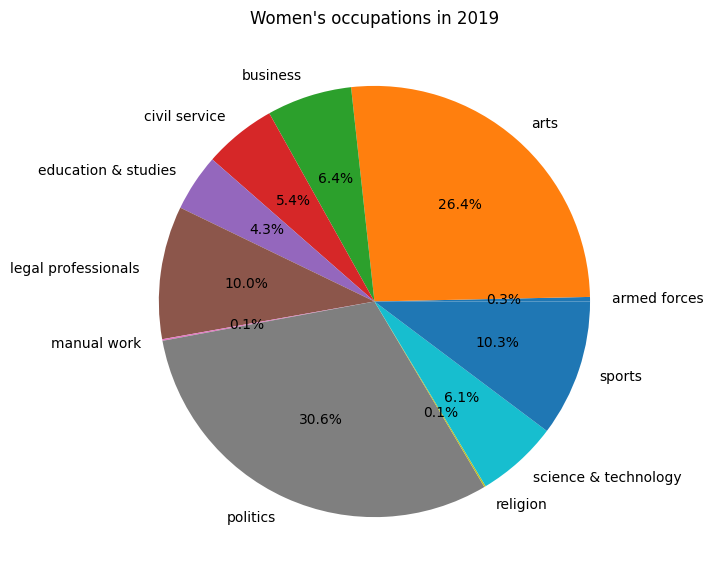

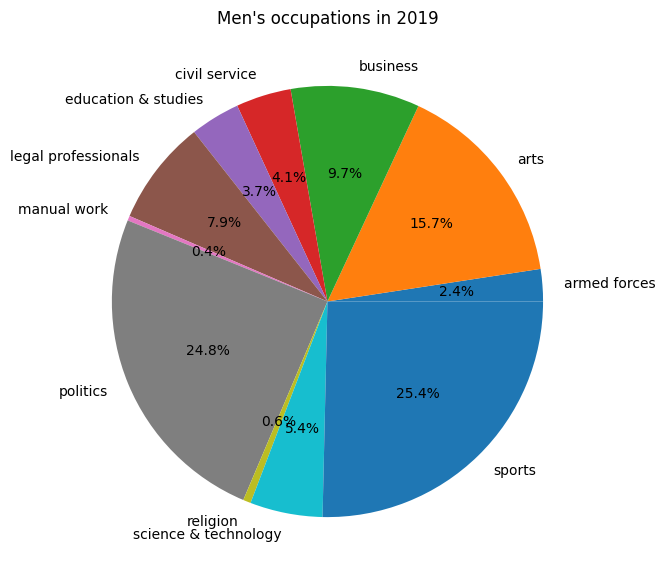

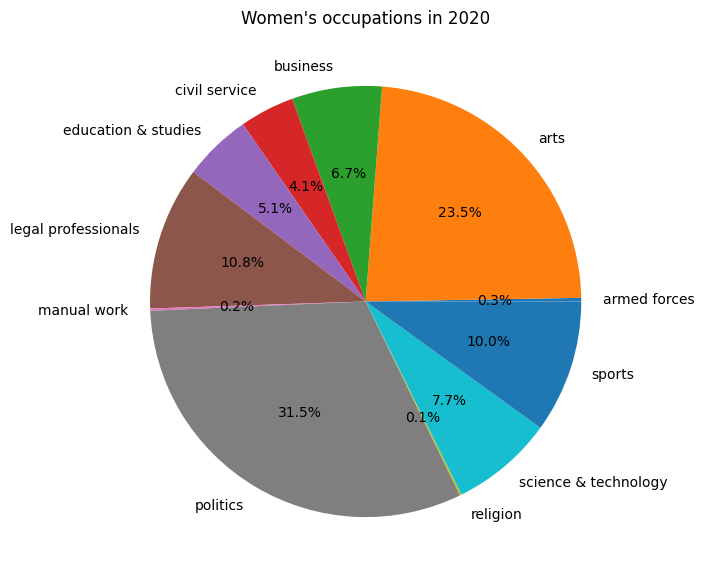

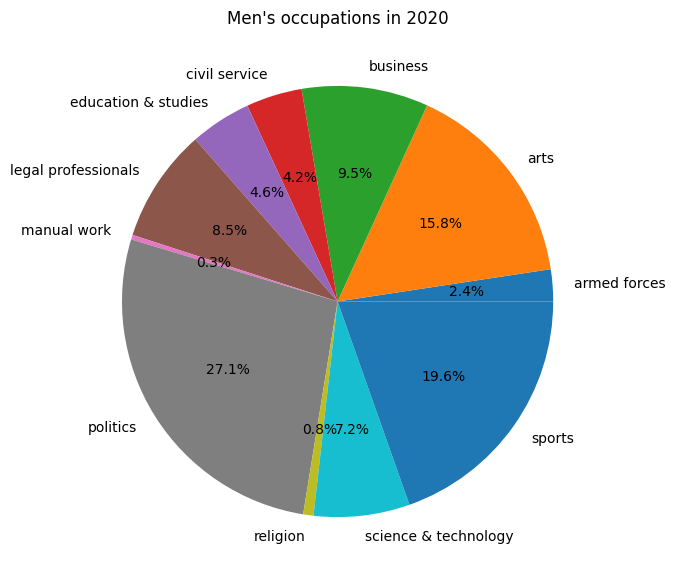

In [49]:
labels=["armed forces", "arts", "business", "civil service",
       "education & studies", "legal professionals", "manual work", "politics",
       "religion", "science & technology", "sports"]
sns.reset_defaults()

for i,year in zip(range(6),years) : 
  plt.figure(figsize=(7,7))
  total_female = data_female_occ[i].sum()
  data_female_occ[i] = data_female_occ[i].apply(lambda x : 100*x/total_female)
  plt.pie(data_female_occ[i].values,labels=labels, autopct='%1.1f%%')
  plt.title("Women's occupations in " + year)
  plt.show()

  plt.figure(figsize=(7,7))
  total_male = data_male_occ[i].sum()
  data_male_occ[i] = data_male_occ[i].apply(lambda x : 100*x/total_male)
  plt.pie(data_male_occ[i].values,labels=labels, autopct='%1.1f%%')
  plt.title("Men's occupations in " + year)
  plt.show()

In [50]:
path_to_sfile = '/content/drive/MyDrive/Results/genders_per_categories-2015.pkl'
with open(path_to_sfile,'rb') as f : 
  tmp_2015 = pkl.load(f)

path_to_sfile = '/content/drive/MyDrive/Results/genders_per_categories-2020.pkl'
with open(path_to_sfile,'rb') as f :
  tmp_2020 = pkl.load(f)

In [51]:
tmp_2015["total"] = tmp_2015["male"].values + tmp_2015["female"].values 
tmp_2015["female"] = 100 * tmp_2015["female"].values/tmp_2015["total"].values
tmp_2015["male"] = 100 * tmp_2015["male"].values/tmp_2015["total"].values

tmp_2020["total"] = tmp_2020["male"].values + tmp_2020["female"].values 
tmp_2020["female"] = 100 * tmp_2020["female"].values/tmp_2020["total"].values
tmp_2020["male"] = 100 * tmp_2020["male"].values/tmp_2020["total"].values

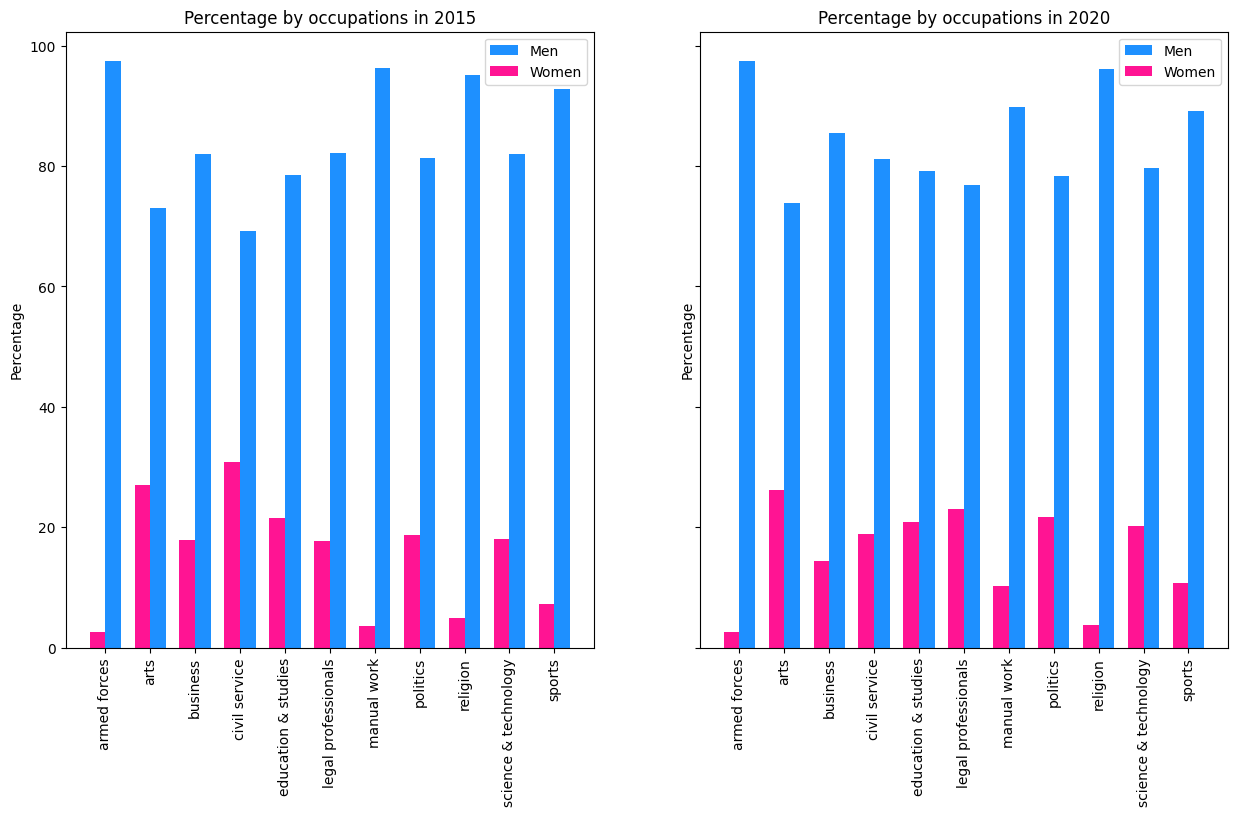

In [55]:
fig, axs = plt.subplots(1,2, figsize=(15,8), sharey=True)
width = 0.35
years=[2015,2020]
datas = [tmp_2015, tmp_2020]

for data, ax, year in zip(datas,axs.flatten(),years) :
  tmp_male=data["male"]
  tmp_female=data["female"]
  x = np.arange(len(labels))
  ax.bar(x+width/2,tmp_male, width, label='Men',color='dodgerblue')
  ax.bar(x-width/2, tmp_female, width, label='Women',color="deeppink")
  ax.set_ylabel('Percentage') 
  ax.set_title('Percentage by occupations in ' + str(year))
  ax.set_xticks(x)
  ax.set_xticklabels(labels,rotation="vertical")
  ax.legend()

### Heatmaps of occupations according to women's and men's age



In [56]:
politic_age_2015 = pd.DataFrame()
politic_age_2020 = pd.DataFrame()
politic_age=[politic_age_2015, politic_age_2020]
years = ['2015','2020']
n_chunks = [208, 53]
for index,year in enumerate(years) : 
  path_to_sfile = '/content/drive/MyDrive/Results/quotes-'+year+'_processed_3.pkl'

  unique_chunk = pd.DataFrame()

  with open(path_to_sfile, 'rb') as f:
    for chunk_idx in range(n_chunks[index]):
      chunk = pkl.load(f)
      unique_chunk = chunk[["gender","category_final", "date_of_birth"]]
      unique_chunk = unique_chunk.dropna(axis=0)
  politic_age[index] = unique_chunk

In [57]:
for data, year, i in zip(politic_age, years,range(10)):
  data["age"] = int(year) - data["date_of_birth"].astype(int)
  data["category_final"] = data["category_final"].apply(lambda x : x[0])
  data["age_intervals"] = pd.cut(x=data["age"], bins = [10,20,30,40,50,60,70,80,90,100])


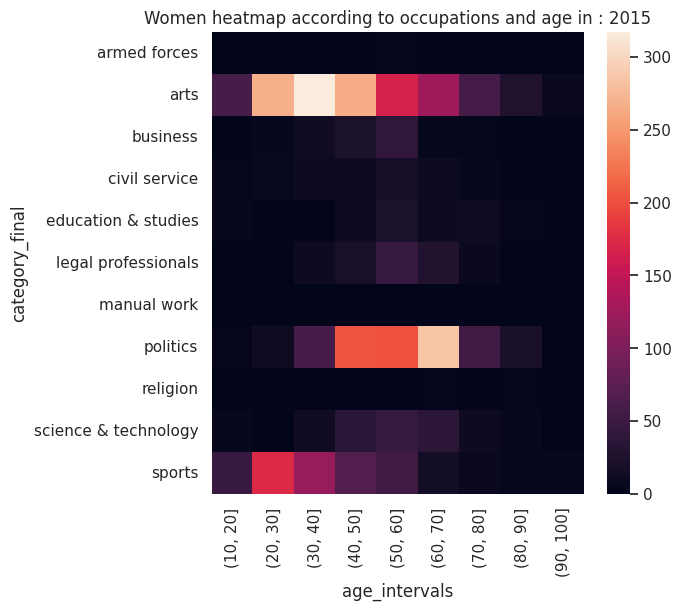

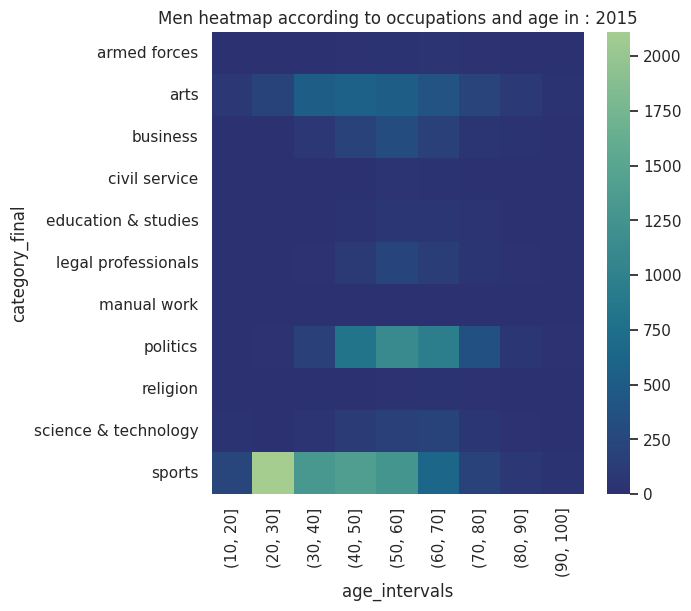

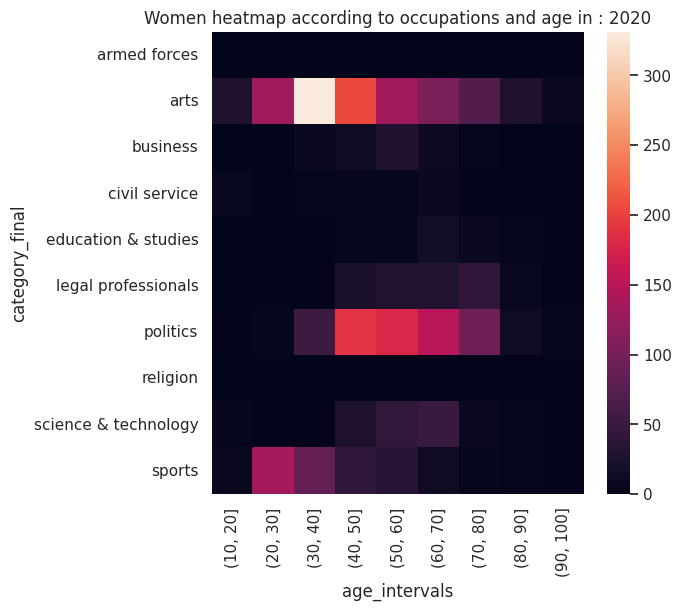

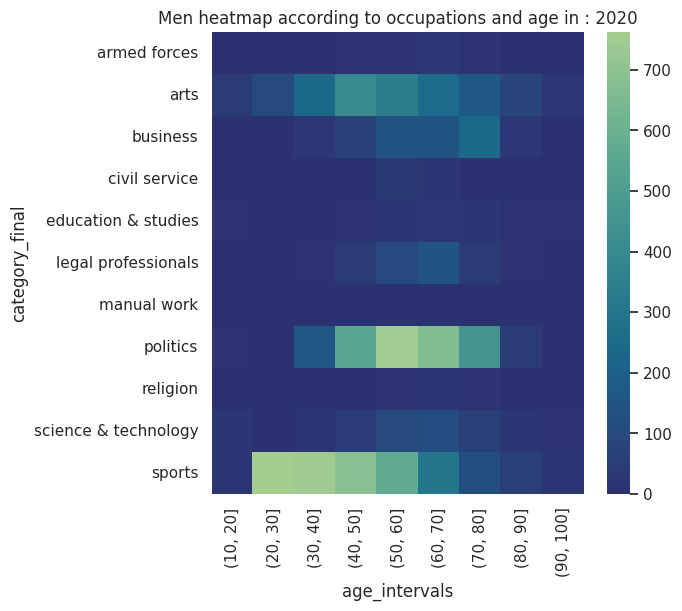

In [61]:
years=[2015,2020]

for data, year in zip(politic_age, years): 
  tmp_female = data[data.gender=="female"]
  tmp_male = data[data.gender=="male"]
  sns.set(rc={"figure.figsize":(6, 6)})
  df2 = pd.crosstab(tmp_female["category_final"],tmp_female["age_intervals"])
  sns.heatmap(df2,cmap="rocket")
  plt.title("Women heatmap according to occupations and age in : {}".format(year))
  plt.show()
  df2 = pd.crosstab(tmp_male["category_final"],tmp_male["age_intervals"])
  sns.heatmap(df2, cmap="crest_r")
  plt.title("Men heatmap according to occupations and age in : {}".format(year))
  plt.show()

## Sentiment Analysis

### Loading and preparing the data and the model

To analyze the sentiment with which a speaker has been quoted, we first extract the context of the quotes in our dataset using the article-centric dataset. In order to only keep quotes present in our dataset, the first thing to obtain is the list of quoteIDs in our dataset for each year.

In [ ]:
# extracting list of quote ids for each year (needed for article-centric dataset extraction)

years = ['2020', '2019', '2018', '2017', '2016', '2015']
n_chunks = [53, 218, 273, 267, 139, 208]

for i,year in enumerate(years):

    path_to_sfile = './data/quotes-'+year+'_processed_merged_2.pkl'
    path_to_dfile = './data/quoteIDs-'+year+'.pkl' 

    quoteids = []
  
    with open(path_to_sfile, 'rb') as f:
        for chunk_idx in range(n_chunks[i]):
            chunk = pkl.load(f)                           # error with pandas 1.0.5!! 1.1.0 ok
            quoteids = quoteids + chunk.quoteID.tolist()
        with open(path_to_dfile, 'wb') as dest: 
            pkl.dump(quoteids, dest)

Then we can proceed to the extraction of the context of each quote.

In [ ]:
def process_artchunk(chunk, path_to_dfile, quoteids):
    chunk.set_index('articleID', inplace=True)
    series = chunk['quotations']
    # put different quotations (dictionnaries with quote attributes) in same article on different cols (same row)
    df = pd.DataFrame(series.tolist(), index=series.index)
    # stack all the columns into a single one -> element in col = dictionnary with quote attributes
    df = df.stack()
    # put elements of each dictionnary in different cols
    df = pd.DataFrame(df.tolist(), index=df.index)
    # keep only desired quote attributes
    df = df[['quoteID', 'leftContext', 'rightContext']]
    # add article title
    tmp  = chunk.loc[set(df.index.get_level_values('articleID')), 'title']
    df = df.merge(tmp, left_on='articleID', right_index=True, how='left')
    # keep only needed quotes
    quoteids_df = pd.DataFrame(quoteids, columns=['ids'])
    df = df.merge(right=quoteids_df, left_on='quoteID', right_on='ids').drop(columns=['ids'])

    # save to pickle
    with open(path_to_dfile, 'ab') as dest: 
        pkl.dump(df, dest)
  
    return len(df)

In [ ]:
# extracting data from article-centric dataset
years = ['2020', '2019', '2018', '2017', '2016', '2015']

n_chunks_article = [0]*len(years)    # needed for read back
n_samples = [0]*len(years)

for i, year in zip(tqdm(range(len(years))), years):
    path_to_sfile = './data/quotebank-'+year+'.json.bz2'  
    path_to_dfile = './data/quotebank-'+year+'_processed.pkl' 
    path_to_quoteids = './data/quoteIDs-'+year+'.pkl'

    with open(path_to_quoteids, 'rb') as f:
        quoteids = pkl.load(f)
  
    df_reader = pd.read_json(path_to_sfile, lines=True, compression='bz2', chunksize=100000)  
    for chunk in df_reader : 
        n_samples[i] += process_artchunk(chunk, path_to_dfile, quoteids)
        n_chunks_article[i] += 1

    print('\nArticle-centric data: year: {}  number of chunks: {}  samples extracted: {}'.format(year, n_chunks_article[i], n_samples[i]))

The following is a screenshot of the prints produced by the above cell.
![print_art_extract](./images/print_art_extract.png)

Now that we have all the contexts of all the quotes present in our dataset, we proceed to analyze them with VADER (Valence Aware Dictionary and Sentiment Reasoner). Each quote has a left and right context, giving two compound scores that we then average.

There are however a few problems that make this operation prone to errors. First, VADER was initially designed for social media analysis so its performance on contexts extracted from news articles might not be as good. Secondly, we can't know for sure that the context is explicitly referring to the wanted speaker or other speakers mentioned in the same article. Finally, other quotes might figure in the context of a given quote in the form [QUOTE]. We found that removing them was not necessary as it did not change the sentiment scores, but still if the quote in the context was referring to the speaker of the studied quote we won't have that information.


    
    
As the article-centric dataset is quite large, we choose to only use a subset (0.75) of all the quotes to reduce processing time.

In [ ]:
def extract_sentiment_score(chunk, path_to_dfile):
    analyzer = SentimentIntensityAnalyzer()
    # use only non-empty contexts
    tmpL = chunk.leftContext.apply(lambda x: len(x)>0)
    tmpR = chunk.rightContext.apply(lambda x: len(x)>0)
    # get compound scores for each L/R context
    chunk['scoreL'] = chunk.loc[tmpL, 'leftContext'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    chunk['scoreR'] = chunk.loc[tmpR, 'rightContext'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    # average L/R context scores
    chunk['score'] = chunk[['scoreL', 'scoreR']].mean(axis=1, skipna=True)
    # remove unnecessary columns
    chunk.drop(columns=['scoreL', 'scoreR'], inplace=True)
    
    with open(path_to_dfile, 'ab') as f:
        pkl.dump(chunk, f)

In [ ]:
# getting sentiment for quotes with article centric dataset
years = ['2020', '2019', '2018', '2017', '2016', '2015']
n_chunks = [81, 173, 165, 142, 68, 102] 

for i,year in enumerate(years):

    path_to_sfile = './data/quotebank-'+year+'_extracted.pkl' 
    path_to_dfile = './data/quotebank-'+year+'_processed.pkl' 
  
    with open(path_to_sfile, 'rb') as f:
        for chunk_idx in range(n_chunks[i]):
            chunk = pkl.load(f)
            # there should be at least one non empty context
            tmp = chunk.leftContext.apply(lambda x: len(x)>0) | chunk.rightContext.apply(lambda x: len(x)>0)
            chunk = chunk[tmp]
            # sample the data
            chunk = chunk.sample(frac=0.75, random_state=123)
            extract_sentiment_score(chunk, path_to_dfile)

The next step consists in merging the data extracted from the article-centric dataset with our original quote dataset. This is basically done by merging on the quoteID which is present in both datasets. Since a quote can appear in different articles, i.e. with different contexts, all the sentiment scores coming from different articles are averaged (not exactly all since we sampled the data). Then the scores are thresholded to classify them between positive, negative or neutral with the threshold suggested in the documentation of VADER, giving a single sentiment for each unique quote present in the sampled data.

In [ ]:
def merge_quote_article_init(qchunk, artchunk):
    init_done = False
    # get scores for quoteIDs present in qchunk
    tmp = artchunk.merge(qchunk.quoteID, how='inner', on='quoteID')
    if len(tmp) == 0: # artchunk has no data corresponding to qchunk quotes so return chunk as it is
        return qchunk, init_done
    # add different scores (different articles) of a quote
    tmp2 = tmp.groupby('quoteID', as_index=False)['score'].agg('sum')
    # keep track of counts to average later
    tmp2['counts'] = tmp.groupby('quoteID', as_index=False)['score'].count()['score']
    # add found scores and counts to qchunk
    qchunk = qchunk.merge(tmp2, how='left', on='quoteID', suffixes=[None, '_y'])
    init_done = True

    return qchunk, init_done

def merge_quote_article(qchunk, artchunk):
    # get scores for quoteIDs present in qchunk
    tmp = artchunk.merge(qchunk.quoteID, how='inner', on='quoteID')
    if len(tmp) == 0: # artchunk has no data corresponding to qchunk quotes so return chunk as it is
        return qchunk
    # add different scores (different articles) of a quote 
    tmp2 = tmp.groupby('quoteID', as_index=False)['score'].agg('sum')
    tmp2['counts'] = tmp.groupby('quoteID', as_index=False)['score'].count()['score'] # can't use numOccurrences for average as we only use a fraction of the full dataset
    qchunk = qchunk.merge(tmp2, how='left', on='quoteID', suffixes=[None, '_y'])
    # aggregate scores with new ones
    tmp3 = qchunk.score.notna() | qchunk.score_y.notna()
    qchunk.loc[tmp3, 'score'] = qchunk.loc[tmp3, ['score', 'score_y']].sum(axis=1, skipna=True)
    qchunk.loc[~tmp3, 'score'] = None
    # aggregate counts with new ones
    tmp3 = qchunk.counts.notna() | qchunk.counts_y.notna()
    qchunk.loc[tmp3, 'counts'] = qchunk.loc[tmp3, ['counts', 'counts_y']].sum(axis=1, skipna=True)
    qchunk.loc[~tmp3, 'counts'] = None
    qchunk.drop(columns=['score_y', 'counts_y'], inplace=True)

    return qchunk

In [ ]:
# merging article dataset with quote dataset ~5h
years = ['2020', '2019', '2018', '2017', '2016', '2015']
n_qchunks = [53, 218, 273, 267, 139, 208]
n_artchunks = [81, 173, 165, 142, 68, 102] 

thresh = 0.05 # from Vader documentation
sentiment_data_idx = pd.MultiIndex.from_product([['negative', 'neutral', 'positive' ], ['female', 'male']], 
                                                names=['sentiment', 'gender'])

for i,year in enumerate(years):
    path_to_sfile_q = './data/quotes-'+year+'_processed_3.pkl'
    path_to_sfile_art = './data/quotebank-'+year+'_processed.pkl' 
    path_to_dfile_q = './data/quotes-'+year+'_processed_4.pkl' 
    path_to_dfile_s = './data/genders_and_sentiment-'+year+'.pkl'

    # DataFrame to keep track of counts of males/females per sentiment type (one for each year)
    df_f = pd.DataFrame(columns=['counts'], index=sentiment_data_idx)
    df_f.fillna(0, inplace=True) 
  
    with open(path_to_sfile_q, 'rb') as f_q:    
        for qchunk_idx in range(n_qchunks[i]):
            qchunk = pkl.load(f_q)
            init_done = False
            with open(path_to_sfile_art, 'rb') as f_art:
                # a quote might appear in different artchunks so need to merge with all of them
                for artchunk_idx in range(n_artchunks[i]):           
                    artchunk = pkl.load(f_art)
                    artchunk.drop(columns=['leftContext', 'rightContext', 'title'], inplace=True)
                    if init_done:
                        qchunk = merge_quote_article(qchunk, artchunk)
                        if qchunk.score.isnull().sum()==0: # if no null then no need to check rest of artchunks (probably won't happen)
                            break
                    else:
                        qchunk, init_done = merge_quote_article_init(qchunk, artchunk)
                    
                # average score
                qchunk['score_avg'] = qchunk.score / qchunk.counts # NaN ok (propagate)
                qchunk.drop(columns=['score', 'counts'], inplace=True)
                # threshold score to get sentiment
                qchunk.loc[qchunk.score_avg>=thresh, 'sentiment'] = 'positive'  # NaN ok (propagate)
                qchunk.loc[qchunk.score_avg<=-thresh, 'sentiment'] = 'negative' # NaN ok (propagate)
                qchunk.loc[qchunk.score_avg.notna() & qchunk.sentiment.isnull(), 'sentiment'] = 'neutral'
                # count gender (M/F) and sentiment for plot
                M_F_only = (qchunk.gender == 'male') | (qchunk.gender == 'female')
                qchunk_red = qchunk.loc[qchunk.sentiment.notna() & M_F_only, ['gender','sentiment']] 
                temp = pd.DataFrame(qchunk_red.groupby('sentiment')['gender'].value_counts()).rename(columns={'gender':'counts'})
                df_f.loc[temp.index] += temp
                
                with open(path_to_dfile_q, 'ab') as qdest:
                    pkl.dump(qchunk, qdest)

        with open(path_to_dfile_s, 'wb') as dest:
            pkl.dump(df_f, dest)   

### Plotting the sentiment according to gender

Here is an example of the dataframes produced by the above cell:

In [62]:
path_to_sfile = '/content/drive/MyDrive/Results/genders_and_sentiment-2015.pkl'
with open(path_to_sfile,'rb') as f : 
  tmp_2015 = pkl.load(f)

path_to_sfile = '/content/drive/MyDrive/Results/genders_and_sentiment-2020.pkl'
with open(path_to_sfile,'rb') as f :
  tmp_2020 = pkl.load(f)

tmp = [tmp_2015,tmp_2020]

In [63]:
tmp_2015

counts
sentiment gender         
negative  female   201198
          male     987035
neutral   female    88604
          male     431523
positive  female   483830
          male    2261516

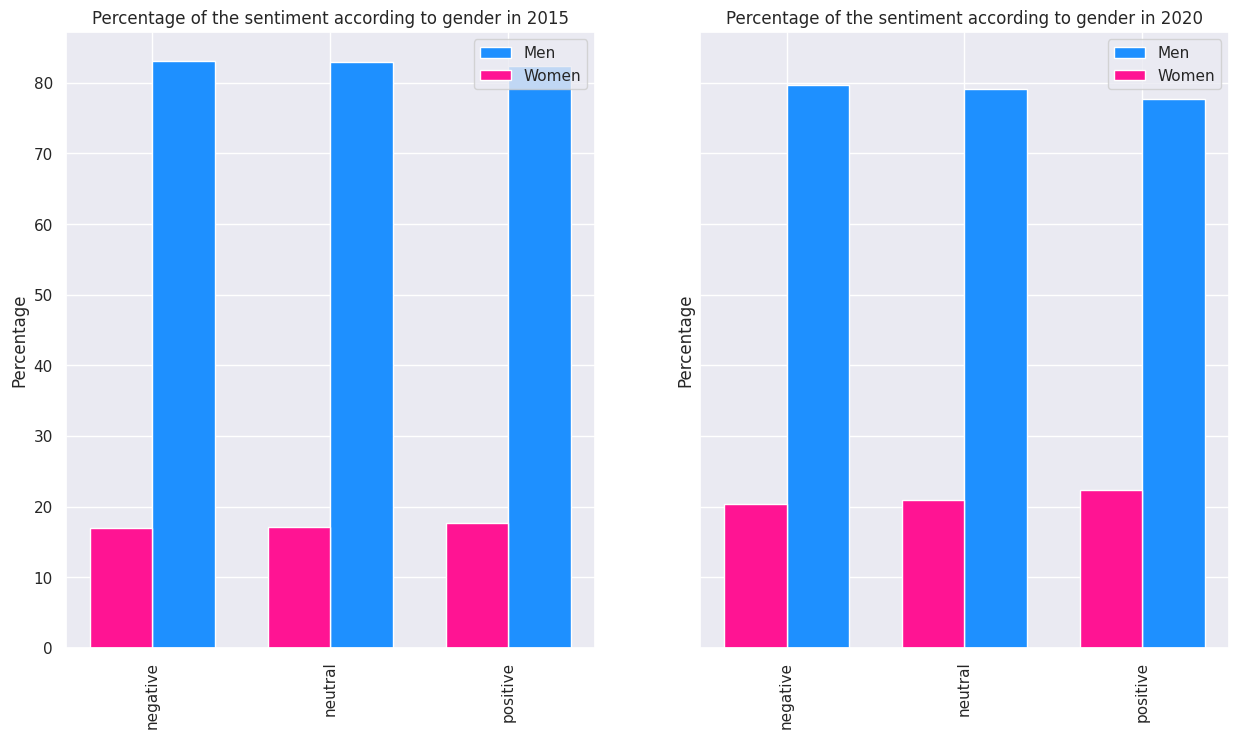

In [64]:
fig, axs = plt.subplots(1,2, figsize=(15,8), sharey=True)
years=[2015,2020]
width = 0.35
labels = ["negative","neutral","positive"]

for tab, ax, year in zip(tmp,axs.flatten(),years) :
  female = {"Sentiment" : ["negative","neutral","positive"],
            "Counts" : [tab.iloc[0].values[0],tab.iloc[2].values[0],tab.iloc[4].values[0]]}
  female = pd.DataFrame(female)
  male = {"Sentiment" : ["negative","neutral","positive"],
            "Counts" : [tab.iloc[1].values[0],tab.iloc[3].values[0],tab.iloc[5].values[0]]}
  male = pd.DataFrame(male)

  female["Total"] = female.Counts.values + male.Counts.values
  female["perc_sent"] = female.Counts.values * 100 / female.Total.values
  male["perc_sent"] = male.Counts.values * 100 / female.Total.values

  label = female.Sentiment.values
  x = np.arange(len(female.Sentiment))
  ax.bar(x+width/2, male["perc_sent"], width, label='Men',color='dodgerblue')
  ax.bar(x-width/2, female["perc_sent"], width, label='Women',color="deeppink")
  ax.set_ylabel('Percentage') 
  ax.set_title('Percentage of the sentiment according to gender in ' + str(year))
  ax.set_xticks(x)
  ax.set_xticklabels(label,rotation="vertical")
  ax.legend()

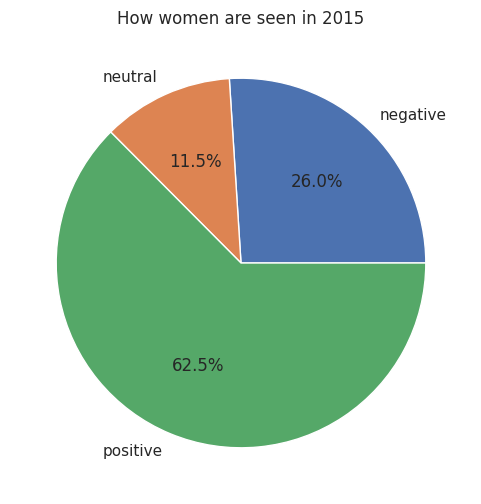

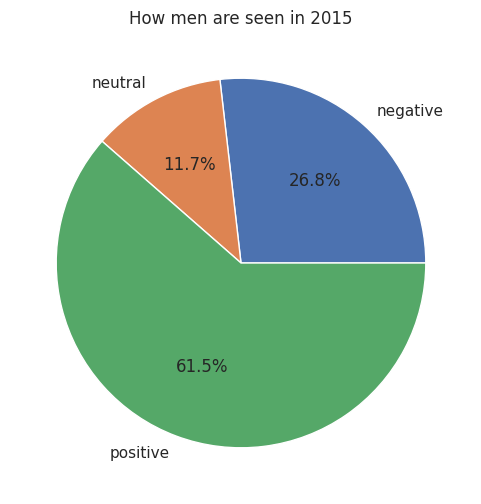

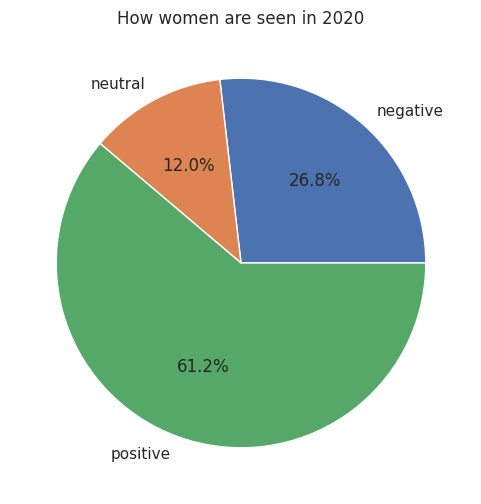

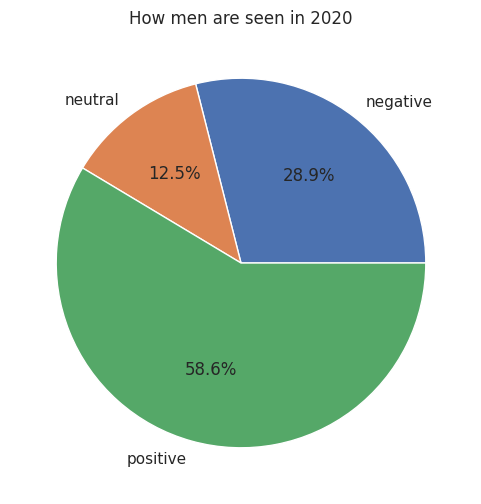

In [66]:
labels=["negative","neutral","positive"]

for tab, ax, year in zip(tmp,axs.flatten(),years) :
  female = {"Sentiment" : ["negative","neutral","positive"],
            "Counts" : [tab.iloc[0].values[0],tab.iloc[2].values[0],tab.iloc[4].values[0]]}
  female = pd.DataFrame(female)
  male = {"Sentiment" : ["negative","neutral","positive"],
            "Counts" : [tab.iloc[1].values[0],tab.iloc[3].values[0],tab.iloc[5].values[0]]}
  male = pd.DataFrame(male)

  female["Total"] = female.Counts.values.sum()
  male["Total"] = male.Counts.values.sum()
  female["perc_gen"] = female.Counts.values * 100 / female.Total.values
  male["perc_gen"] = male.Counts.values * 100 / male.Total.values
  plt.pie(female.perc_gen.values,labels=labels, autopct='%1.1f%%')
  plt.title("How women are seen in " + str(year))
  plt.show()

  plt.pie(male.perc_gen.values,labels=labels, autopct='%1.1f%%')
  plt.title("How men are seen in " + str(year))
  plt.show()
